# Анализ данных медицинского центра (NDA)

## 1. Цель и задачи проекта

Проект представляет собой исследовательский анализ данных медицинского центра в РФ (NDA).

**Цель проекта** - провести анализ изменения цены лечения в медицинском центре в 2022 году относительно 2021 году, а также определить возможные ключевые драйверы изменения цен.

**Задачи проекта:**
1. Подключить необходимые библиотеки для проведения анализа данных;
2. Импортировать датасет, по возможности не использовать локальное решение;
3. Провести предобработку данных;
4. Провести исследовательский анализ данных с выдвижением 3 гипотез;
5. Формулирование общего вывода исследования.

## 2. Подготовка к проведению исследования

In [1]:
# импортируем необходимые библиотеки для проведения анализа и визуализации данных в дальнейшем
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from io import BytesIO
import requests
import openpyxl

In [2]:
# настраиваем подключение к файлу, расположенному на Google Drive, актуальный путь к файлу не указывается, так как
# проект находится под NDA
spreadsheet_id = 'id'

file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)

r = requests.get(file_name)

In [3]:
# проведем подключение к датасету и проверим корректность отображения данных
df = pd.read_excel(BytesIO(r.content))
df.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                        service_name  service_amount  \
0                                    Прием первичный            1470   
1  Взятие материала на посев, цитологическое иссл...             284   
2  Посев отдел, дыхательных путей - слизистая зев...            1134   
3      Общий анализ крови (лейкоцитарная форм,, СОЭ)             693   
4                                Ревматоидный фактор             420   

   service_number  insured  sex_id  age_for_service_date  
0               1   490777     2.0                    26  
1               1   490777     2.0                    26  
2               1   490777     2.0                    26  
3               1   490777     2.0                    26  
4               1   490777     2.0                    26

## 3. Предобработка данных

В рамках данного раздела последовательно проведем предобработку данных: в частности, проверим типы данных на соответствие значений, наличие пропусков и дубликатов. Для начала выведем общую информацию о датасете.

In [4]:
# выводим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


Видим, что в датасете отсутствуют пропуски за исключением колонки `sex_id` - пола, названия колонок единообразны и удобны для дальнейшей работы. Также в датасете необходимо поменять тип данных в одной колонке - `service_date` на datetime. Колонку `sex_id` также можно было бы поменять на тип int64, так как она содержит 2 варианта целого числа, но так как в этой колонке есть пропуски, то оставим ее в формате float в силу проблем с конвертацией в целочисленное значение.

In [5]:
# преобразуем типы данных
df['service_date'] = pd.to_datetime(df['service_date'])
df['service_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 85369 entries, 0 to 85368
Series name: service_date
Non-Null Count  Dtype         
--------------  -----         
85369 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 667.1 KB


Заполним пропуски в столбце с полом на формальную заглушку - **'пол не указан'**, а также рассмотрим датасет на наличие дубликатов.

In [6]:
# заполняем пропуски в столбце с полом
df['sex_id'] = df['sex_id'].fillna('пол не указан')

In [7]:
# также рассмотрим датасет на наличие дубликатов
df.duplicated().sum()

0

В датасете отсутствуют дубликаты. Проверять отдельные столбцы нет смысла в силу того, что они могут дублироваться, но это не значит, что они являются дубликатами.

**Подведем промежуточные результаты по этапу предобработки данных:**
- В ходе работы был изменен тип данных в колонке `service_date` с object на datetime;
- Единственная колонка с пропусками - `sex_id`, заменили пропуски на заглушку для дальнейшего анализа и визуализаций;
- Дубликатов в датасете обнаружено не было.

Данные подготовлены к проведению дальнейшего анализа.

## 4. Исследовательский анализ данных

Для выдвижения гипотез необходимо провести исследовательский анализ данных. Для этого проанализируем наименования услуг за разные годы, количество реализиованных услуг, сумма выплат, распределение по полу и возрасту. Начнем с того, что проанализируем перечни услуг за 2021 и 2022 годы - если наименования идентичны, то можно проводить сравнительный анализ по каждому периоду.

In [8]:
# создадим вспомогательный столбец с годом
df['year'] = df['service_date'].dt.year

In [9]:
# делаем срез данных за 2021 год и выводим уникальный перечень услуг
df.query('year == 2021')['service_name'].unique()

array(['Прием первичный',
       'Взятие материала на посев, цитологическое исследование ( риноцитограмма)',
       'Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам',
       'Общий анализ крови (лейкоцитарная форм,, СОЭ)',
       'Ревматоидный фактор', 'С-реактивный белок',
       'Взятие крови из периферической вены', 'Магнитотерапия (1 сеанс)',
       'УВЧ-терапия (1 сеанс) (1 поле)', 'Прием повторный',
       'Смазывание глотки лекарственными формами', 'Взятие мазка',
       'Обработка вульвы', 'Обработка шейки матки',
       'Гинекологический мазок', 'Общий анализ мочи', 'Креатинин',
       'Мочевая кислота', 'Мочевина', 'Общий белок',
       'Ультразвуковое исследование почек и надпочечников',
       'Ультразвуковое исследование мочевого пузыря',
       'ЛПНП (липопротеиды низкой плотности, бета-липопротеиды)',
       'Триглицериды', 'Холестерин', 'АЛТ (аланинаминотрансфераза)',
       'Альдостерон', 'Кортизол (кровь)', 'Ренин + Ангио

In [10]:
# аналогичное за 2022 год
df.query('year == 2022')['service_name'].unique()

array(['Магнитотерапия (1 сеанс)', 'СМТ-форез (1 сеанс) (2 поля)',
       'Прием невролога, повторный', 'Прием физиотерапевта, повторный',
       'Классический лечебный массаж шейно-грудного отдела',
       'Прием отоларинголога, первичный',
       'Общий анализ крови (лейкоцитарная форм,, СОЭ)',
       'Общий анализ мочи', 'Взятие крови из периферической вены',
       'Прием отоларинголога, повторный',
       'Рентгенография органов грудной клетки ( 2 проекции )',
       'Прием трапевта, первичный',
       'Ультразвуковое исследование гинекология трансвагинально с ДС сосудов',
       'Прием гинеколога, первичный', 'Взятие мазка',
       'Снятие ЭКГ (без интерпретации и описания)',
       'Прием терапевта , повторный',
       'Продувание слуховых труб по Политцеру с двух сторон',
       'Удаление серной пробки  (за одно ухо)',
       'Туалет слухового прохода', 'Тимпанометрия',
       'Анемизация слизистой носа', 'Прием хирурга, первичный',
       'Дуплексное сканирование вен нижних ко

Видим, что наименования услуг несколько отличаются, однако в отсутствии прочих данных сделать с этим ничего нельзя, поэтому будет работать с тем, что есть. Проанализируем распределение клиентов в клинике по полу и возрасту за 2 года, для этого создадим дополнительную колонку по возрастным даиапазонам, за основу возьмем шаг в 10 лет.

### 4.1. Исследование поло-возрастных характеристик клиентов

In [11]:
# определяем диапазоны возрастов, шаг 10 лет
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# создадим новую колонку с диапазонами при помощи соответствующего метода
df['age_group'] = pd.cut(df['age_for_service_date'], bins=bins, labels=[f"{i}-{i+9}" for i in range(0, 100, 10)])

# группируем данные
df_grouped_by_age_sex = pd.DataFrame(df.groupby(['age_group', 'sex_id'])['record_id'].count()).reset_index(level=\
                                    ['age_group', 'sex_id'])

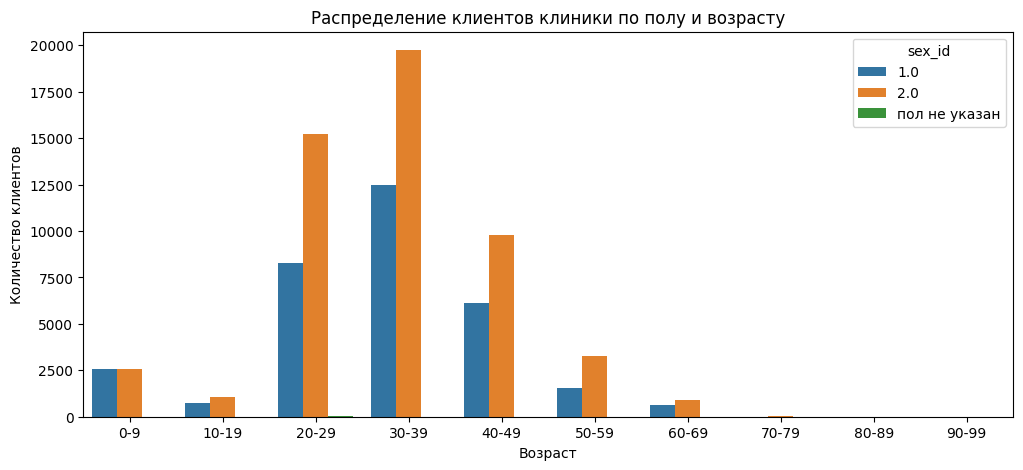

In [12]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_age_sex, x='age_group', y='record_id', hue='sex_id')
plt.title('Распределение клиентов клиники по полу и возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')

plt.show()

На графике видно, что большинство клиентов клиники - женщины, при это доминирующий возраст - 30-39 лет. Также встречаются пациенты женщины в возрасте 20-29 и 40-49 лет. Наименьшая группа пациентов - дети/подростки в возрасте 10-19 лет и пожилые люди от 50 до 79 лет. Сравним распределения за 2021 и 2022 год.

In [13]:
# снова сгруппируем данные, предварительно выполнив срез за 2021 год
df_grouped_by_age_sex_2021 = pd.DataFrame(df.query('year == 2021').groupby(['age_group', 'sex_id'])['record_id'].count\
                                          ()).reset_index()

# делаем аналогичный срез за 2022 год
df_grouped_by_age_sex_2022 = pd.DataFrame(df.query('year == 2022').groupby(['age_group', 'sex_id'])['record_id'].count\
                                          ()).reset_index()

In [14]:
# определяем параметры фигур, используем параметр sharey для отображения графиков на одной строке
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_age_sex_2021, x='age_group', y='record_id', hue='sex_id', ax=axes[0])
ax2 = sns.barplot(data=df_grouped_by_age_sex_2022, x='age_group', y='record_id', hue='sex_id', ax=axes[1])

plt.show()

В целом, поло-возрастное распределение за 2 года имеет схожую форму: единственная разница заметна в первом сегменте - в 2021 году большая часть детей были женского пола, а в 2022 - мужского. Разница едва ощутима, так как распределены они практически поровну. Далее проанализируем наиболее популярные типы услуг: для этого сгруппируем значения и выведем ТОП-10.

### 4.2. Исследование типов услуг

In [15]:
# группируем данные
df_grouped_by_service = pd.DataFrame(df.groupby('service_name')['record_id'].count()).sort_values(by='record_id',\
                                    ascending=False).reset_index().head(11)

In [16]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_service, x='service_name', y='record_id')
plt.title('ТОП-10 наиболее популярных услуг')
plt.xlabel('Услуга')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=30, ha='right')

plt.show()

На графике видно, что наиболее популярными услугами являются первичный и вторичный приемы, а также авзятие, анализ крови и магнитотерапия. Кроме того, популярными являются также и другие виды анализов, указанные на графике. Ранее уже было сказано, что перечни услуг за 2021 и 2022 годы отличаются, поэтому целесообразно проанализировать каждый год по отдельности, так как на графике могут пересекаться одинаковые по содержанию услуги за 2 года.

In [17]:
# снова сгруппируем данные, предварительно выполнив срез за 2021 год
df_grouped_by_service_2021 = pd.DataFrame(df.query('year == 2021').groupby('service_name')['record_id'].count()\
                                          .sort_values(ascending=False).reset_index().head(11))
# делаем аналогичный срез за 2022 год
df_grouped_by_service_2022 = pd.DataFrame(df.query('year == 2022').groupby('service_name')['record_id'].count()\
                                          .sort_values(ascending=False).reset_index().head(11))

In [18]:
# определяем параметры фигур
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_service_2021, x='service_name', y='record_id', ax=axes[0])
ax1.set_title('ТОП-10 услуг за 2021 год')
ax1.set_xlabel('Услуга')
ax1.set_ylabel('Количество клиентов')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

ax2 = sns.barplot(data=df_grouped_by_service_2022, x='service_name', y='record_id', ax=axes[1])
ax2.set_title('ТОП-10 услуг за 2022 год')
ax2.set_xlabel('Услуга')
ax2.set_ylabel('Количество клиентов')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

На графиках можно заметить следующие особенности:
- во-первых, количество обращений в 2022 году значительно меньше, чем в 2021 году. Для этого необходимо рассчитать совокупное количестов обращений, а также дату даты первого и последнего обращений за каждый год. Вполне вероятно, данные за 2022 год просто представлены не в полном виде;
- во-вторых, на общем графике действительно пересекались услуги, которые относятся к двум периодам: в 2021 году существует общая услуга в виде первичного и вторичного приема. Можно предположить, что туда входят приемы по всем врачам в целом. В 2022 году перечень услуг становится точнее и, вероятно, каждый врач имеет свои отдельные первичный и вторичный приемы.

Так или иначе, в оба периода доминируют различные типы анализов: взятие и анализ крови, магнитотерапия, мазок, анализ мочи, лазеротерапия и так далее, а также приемы - общие в 2021 году и первичные приемы гинеколога, терапевта, отоларинголога и невролога в 2022 году. Сравним количество и даты обращения за два года.

In [19]:
# рассчитаем количество обращений за 2021 год
print('Количество обращений за 2021 год составило:', df.query('year == 2021')['record_id'].count())

Количество обращений за 2021 год составило: 44392


In [20]:
# рассчитаем количество обращений за 2022 год
print('Количество обращений за 2022 год составило:', df.query('year == 2022')['record_id'].count())

Количество обращений за 2022 год составило: 40977


In [21]:
# определим даты первого и последнего обращений за 2021 год
print('Дата первого обращения в 2021 году:', df.query('year == 2021')['service_date'].min())
print('Дата последнего обращения в 2021 году:', df.query('year == 2021')['service_date'].max())

Дата первого обращения в 2021 году: 2021-01-03 00:00:00
Дата последнего обращения в 2021 году: 2021-12-31 00:00:00


In [22]:
# определим даты первого и последнего обращений за 2022 год
print('Дата первого обращения в 2022 году:', df.query('year == 2022')['service_date'].min())
print('Дата последнего обращения в 2022 году:', df.query('year == 2022')['service_date'].max())

Дата первого обращения в 2022 году: 2022-01-03 00:00:00
Дата последнего обращения в 2022 году: 2022-08-31 00:00:00


Исходя из полученных результатов можно сделать следующие выводы: количество обращений за 2022 год оказывается меньше, чем за 2021 год, но всего лишь на 8%. Более того, в 2021 году данные представлены в полном формате за весь год, а в 2022 году - только по 31 августа. Вполне вероятно, что количество посещений за 2022 год превосходит количество посещений за 2021 год, поэтому если вернуться к графику с ТОП-10 сервисов можно отметить, что данные на нем распределены более равномерно: вполне вероятно, что посещения по первичному и вторичному приемам равномерно распределились по всем врачам. Для того, чтобы проанализировать распределение по типам врачей в 2022 году, подготовим дополнительную таблицу и визуализацию.

In [23]:
# делаем срез за 2022 год, используем дополнительную фильтрацию по содержанию слова "Прием" в наименовании услуги
df_grouped_by_doctors_2022 = pd.DataFrame(df.query('year == 2022 and service_name.str.contains("Прием")').groupby\
                                          ('service_name')['record_id'].count().sort_values(ascending=False)\
                                          .reset_index())

# рассчитаем сумму посещений по данным типам услуг для перевода показателей из абсолютных в относительные значения
total_records = df_grouped_by_doctors_2022['record_id'].sum()

# рассчитаем относительные показатели, отсортируем по тем, что больше 2%
df_grouped_by_doctors_2022['record_id_percentage'] = (df_grouped_by_doctors_2022['record_id'] / total_records) * 100

df_grouped_by_doctors_2022 = df_grouped_by_doctors_2022.query('record_id_percentage > 2')

In [24]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_doctors_2022, x='record_id_percentage', y='service_name', orient='h')
plt.title('Распределение по профилю врачей')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

На графике видно, что наиболее популярными являются приемы гениколога (при этом лидирует именно повторный прием), а также первичный прием терапевта - занимают более 7% от совокупного количества. Кроме этого, популярностью пользуются первичный прием отоларинголога, невролога и повторный прием терапевта. Для упрощения анализа разделим сегментируем данные по типу приемов, чтобы узнать, какие именно профили врачей пользуются спросом на первочном и повторном этапах.

In [25]:
# делаем срез данных по первичным приемам
df_grouped_by_doctors_2022_first = df_grouped_by_doctors_2022.query('service_name.str.contains("первичный")')\
                                   .reset_index(drop=True)

# делаем срез данных по повторным приемам
df_grouped_by_doctors_2022_second = df_grouped_by_doctors_2022.query('service_name.str.contains("повторный")')\
                                   .reset_index(drop=True)

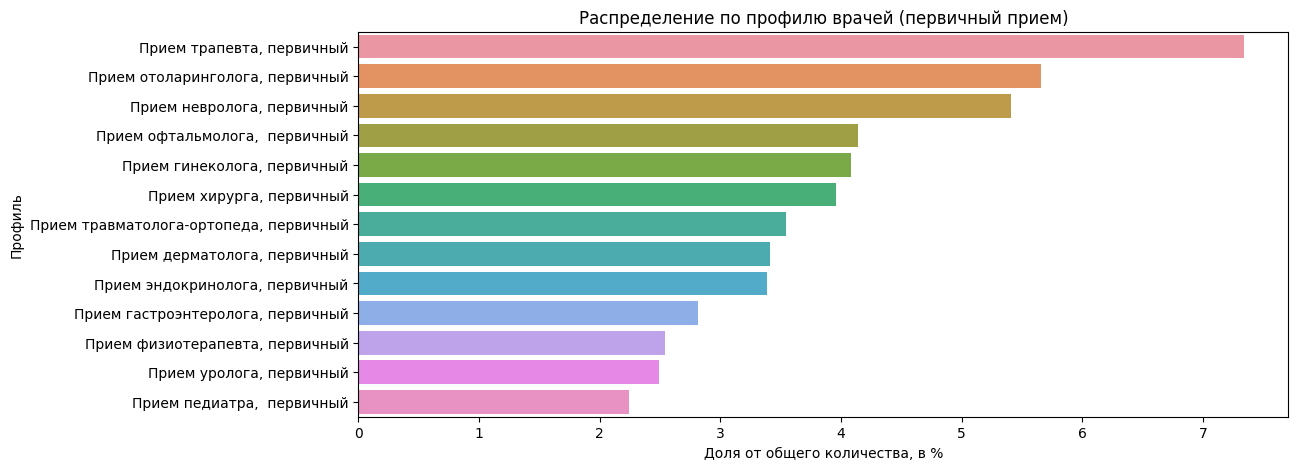

In [26]:
# построим график по первичным приемам
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_doctors_2022_first, x='record_id_percentage', y='service_name', orient='h')
plt.title('Распределение по профилю врачей (первичный прием)')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

В рамках первичного приема особым спросом пользуется терапевт (более 7%), отоларинголог (более 5%), невролог (также более 5%), офтальмолог, гинеколог и хирург (более 4%). В меньшей степени спросом пользуются гастроэнтеролог, физиотерапевт, уролог, педиатр (чуть больше 2%) и прочие профили врачей, которые не вошли в данную группу. Проанализируем распределение профилей врачей по повторным приемам.

In [27]:
# построим график по повторным приемам
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_doctors_2022_second, x='record_id_percentage', y='service_name', orient='h')
plt.title('Распределение по профилю врачей (первичный прием)')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

Разница заметна: в большей степени на повторный прием обращаются к гинекологу (более 7%), а также к терапету (чуть меньше 5%). В средней степени клиенты обращаются за повторной консультацией к неврологу, травматологу-ортопеду, гастроэнтерологу и урологу (чуть больше 3%). Отоларинголог, эндокринолог и физиотерапевт пользуются меньшим спросом на повторных консультациях (2-2.5%), как и прочие профили, которыен не вошли в данную группу. Наконец, сравним количество первичных и повторных обращений.

In [28]:
# сравним количество первичных и повторных обращений
print('Количество первичных обращений за 2022 год составляет:', df_grouped_by_doctors_2022.query('service_name.str.\
     contains("первичный")')['record_id'].sum(),'\n'
      'Количество повторных обращений за 2022 год составляет:', df_grouped_by_doctors_2022.query('service_name.str.\
     contains("повторный")')['record_id'].sum(),'\n'
      'Соотношение первичных и вторичных обращений:', ((df_grouped_by_doctors_2022.query('service_name.str.\
     contains("первичный")')['record_id'].sum() / df_grouped_by_doctors_2022.query('service_name.str.\
     contains("повторный")')['record_id'].sum()) * 100).round(2), ', первичных обращений больше на',
     (((df_grouped_by_doctors_2022.query('service_name.str.contains("первичный")')['record_id'].sum() /
     df_grouped_by_doctors_2022.query('service_name.str.contains("повторный")')['record_id'].sum()) * 100) - 100).\
     round(2), 'процента.')

Количество первичных обращений за 2022 год составляет: 6507 
Количество повторных обращений за 2022 год составляет: 4028 
Соотношение первичных и вторичных обращений: 161.54 , первичных обращений больше на 61.54 процента.


### 4.3. Анализ стоимостных показателей

#### 4.3.1. Общий анализ стоимостных показателей

Рассчитаем среднюю стоимость всех услуг за 2021 и 2022 год: для этого сделаем срез данных таким образом, чтобы количество услуг составляло всего единицу. Таким образом, мы узнаем цену за каждую услугу. Вполне вероятно, что в клинике работают скидки и программы лояльности для разных категорий клиентов, поэтому данный способ анализа необходимо прояснить с заказчиком: в дальнейшем мы проведем проверку на разницу по поло-возрастным характеристикам, но может быть и такое, что основания для разной цены другое - например, количество услуг, LTV клиента в клинике и так далее. Так как основная цель исследования заключается в определении драйверов изменения цены, то в данном разделе будут предлагаться соответствующие гипотезы, однако начать необходимо с общего анализа стоимостных показателей.

In [29]:
# рассчитаем медианную стоимость услуг за 2 года
print('Медианная стоимость услуг за 2021 и 2022 год составляет:', df.query('service_number == 1')['service_amount'].median(),
      'рублей')

Медианная стоимость услуг за 2021 и 2022 год составляет: 1155.0 рублей


In [30]:
# рассчитаем медианную стоимость услуг за 2021 год
print('Медианная стоимость услуг за 2021 год составляет:', df.query('year == 2021 and service_number == 1')['service_amount']\
      .median(), 'рублей')

Медианная стоимость услуг за 2021 год составляет: 1113.0 рублей


In [31]:
# рассчитаем медианную стоимость услуг за 2022 год
print('Медианная стоимость услуг за 2022 год составляет:', df.query('year == 2022 and service_number == 1')['service_amount']\
      .median(), 'рублей')

Медианная стоимость услуг за 2022 год составляет: 1200.0 рублей


В качестве оценке центрального значения использовалась медиана, так как она наиболее устойчива к выбросам в отличие от среднего значения. Рассмотрим распределение цены на показатели однородности при помощи боксплотов.

In [32]:
# построим график
plt.figure(figsize=(12, 5))
sns.boxplot(data=df.query('service_number == 1'), x='year', y='service_amount')
plt.title('Распределение цены по годам')
plt.xlabel('Год')
plt.ylabel('Стоимость')

plt.show()

Видим, что в данных есть выбросы - начинаются они примерно с 4500 руб. Посмотрим на данные типы услуг более внимательно.

In [33]:
# сделаем срез данных по цене выше 4500 руб.
df.query('service_number == 1 and service_amount > 4500')

record_id service_date  \
477    30268204703   2021-01-22   
565    30268213503   2021-01-22   
637    30268220703   2021-01-10   
1495   30268306803   2021-01-23   
1983   30268355603   2021-01-27   
...            ...          ...   
84562  33178018103   2022-08-29   
85048  33178102103   2022-08-19   
85058  33178103103   2022-08-26   
85341  33178144403   2022-08-09   
85344  33178144703   2022-08-13   

                                            service_name  service_amount  \
477                      Вакцинация вакциной "Пентаксим"            4652   
565              Вскрытие абсцесса различной локализации            6405   
637              Вскрытие абсцесса различной локализации            6405   
1495       МРТ пояснично-крестцового отдела позвоночника            5145   
1983                             Удаление вросшего ногтя            6300   
...                                                  ...             ...   
84562                         МРТ тазобедренных суставов            7720   
85048  Прием врача эндокринолога, руководителя направ...            5510   
85058                  МСКТ мягких тканей шеи с фонацией            8270   
85341                     Вакцинация вакциной "Менактра"            9000   
85344                    Вакцинация вакциной "Варилрикс"            4600   

       service_number  insured sex_id  age_for_service_date  year age_group  
477                 1   221620    2.0                     1  2021       0-9  
565                 1   386877    1.0                    48  2021     40-49  
637                 1   402161    2.0                    35  2021     30-39  
1495                1   490941    2.0                    29  2021     20-29  
1983                1   168236    1.0                    13  2021     10-19  
...               ...      ...    ...                   ...   ...       ...  
84562               1   576389    1.0                    25  2022     20-29  
85048               1  1155117    1.0                    59  2022     50-59  
85058               1  1155117    1.0                    59  2022     50-59  
85341               1  1155165    2.0                     0  2022       NaN  
85344               1  1155165    2.0                     0  2022       NaN  

[288 rows x 10 columns]

Видим, что в таблице присутствуют операции, МРТ, вакцинации, а также прием врача-руководителя направления, что оправдывает стоимость услуг. Подобное, разумеется, выбросами считать нельзя, но визуализировать датасет без них также было бы интересно и более наглядно.

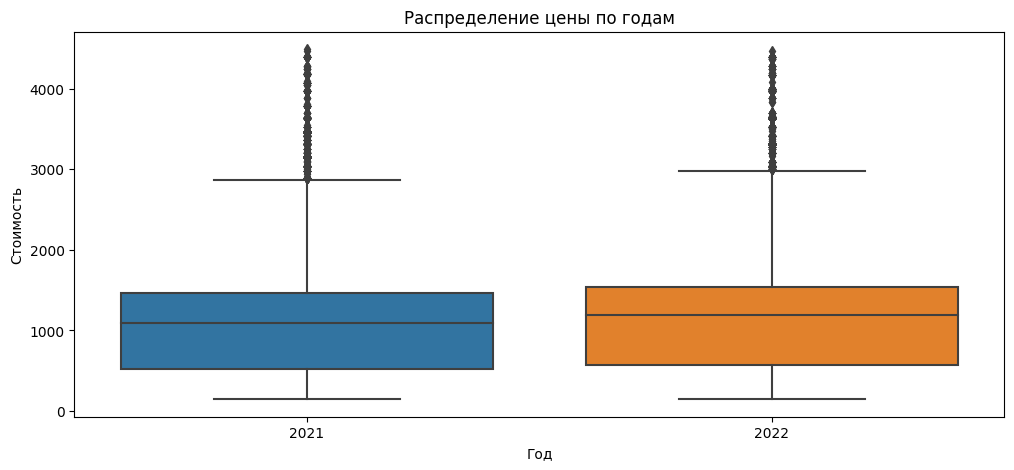

In [34]:
# построим дополнительный график
plt.figure(figsize=(12, 5))
sns.boxplot(data=df.query('service_number == 1 and service_amount < 4500'), x='year', y='service_amount')
plt.title('Распределение цены по годам')
plt.xlabel('Год')
plt.ylabel('Стоимость')

plt.show()

Таким образом, можно говорить о том, что стоимость услуг за 2021 и 2022 год, в целом, не сильно отличается: медианное значение варьируется в районе 1100-1200 руб., 25%-перцентиль - в районе 500 руб., то есть 75% реализиованных услуг обладают стоимостью в более 500 руб., а 75% - около 1500 руб., что указывает на то, что только 25% оказанных услуг выше данной стоимости. При этом в районе 300 услуг были оказаны на сумму свыше 3000 рублей, на что указывают: а) количество строк в таблице среза выше, б) наличие выбросов на графике. Также рассчитаем совокупную выручку за оба года, чтобы получить общую картину за анализируемые периоды.

In [106]:
import scipy.stats as st

x1 = df.query('service_number == 1 and service_amount < 4500 and year == 2021')['service_amount']
x2 = df.query('service_number == 1 and service_amount < 4500 and year == 2022')['service_amount']

alpha = 0.05

test_results = st.ttest_ind(x1, x2, equal_var=False)

if alpha < test_results.pvalue:
  print(f"Различия статистически не значимы, отклонить нулевую гипотезу нельзя, так как P-value равен {test_results.pvalue}")
else:
  print(f"Различия статистически значимы, отклонить нулевую гипотезу можно, так как P-value равен {test_results.pvalue}")

Различия статистически значимы, отклонить нулевую гипотезу можно, так как P-value равен 2.268132254769736e-44


In [35]:
# сгруппируем данные по году и рассчитаем совокупную выручку
df_grouped_by_rev_and_year = df.groupby('year')['service_amount'].sum().reset_index()

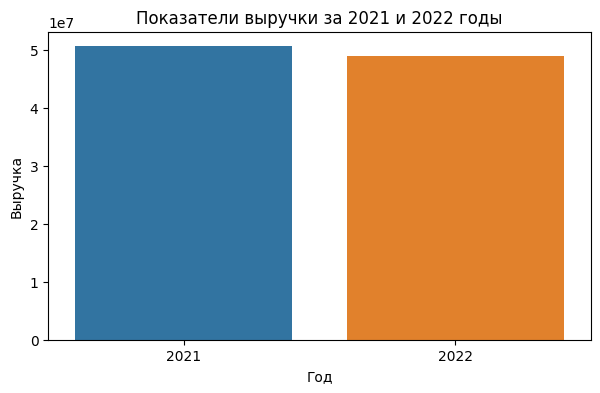

In [36]:
# построим график
plt.figure(figsize=(7, 4))
sns.barplot(data=df_grouped_by_rev_and_year, x='year', y='service_amount')
plt.title('Показатели выручки за 2021 и 2022 годы')
plt.xlabel('Год')
plt.ylabel('Выручка')

plt.show()

В целом, выручка за 2021 год не сильно отличается от 2022 года: да, она оказывается выше, но стоиит учитывать относительно небольшую разницу, а также то, что данные за 2022 год представлены за 3 квартала. Вполне вероятно, что в 2022 году выручка окажется больше. Рассчитаем AOV (средний чек) на одного клиента и проанализируем его отдельно от боксплотов.

In [37]:
# сгруппируем данные по году и рассчитаем среднюю выручку
df_grouped_by_avg_rev_per_year = df.groupby('year')['service_amount'].mean().reset_index()

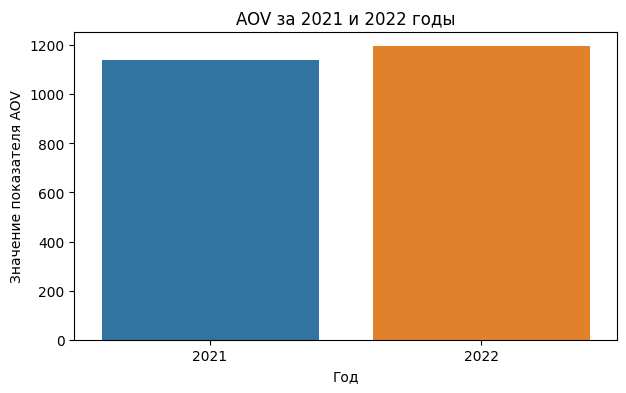

In [38]:
# построим график
plt.figure(figsize=(7, 4))
sns.barplot(data=df_grouped_by_avg_rev_per_year, x='year', y='service_amount')
plt.title('AOV за 2021 и 2022 годы')
plt.xlabel('Год')
plt.ylabel('Значение показателя AOV')

plt.show()

AOV зв 2022 год оказывается больше, чем в 2021 году, что указывает на то, что, в среднем, один клиент в клинике генерирует больше выручки, чем в 2021 году, однако данный показатель не сильно отличается от показателя за предыдущий период. Вернемся к анализу цены и рассмотрим ее в разрезе сегментации по типам услуг: в рамках каждой категории можно будет выделить ТОП-3 сервиса по цене и проанализировать их популярность среди клиентов клиники. Для определения шага сегментации узнаем минимальную и максимальную цены в клинке.

In [39]:
# узнаем минимальную стоимость услуг в кликнике
print('Минимальная стоимость услуг составяет', df.query('service_number == 1 and service_amount < 4500')['service_amount']\
      .min(), 'руб.')

Минимальная стоимость услуг составяет 147 руб.


In [40]:
# узнаем максимальную стоимость услуг в кликнике (за исключением слишком крупных значений)
print('Максимальная стоимость услуг составяет', df.query('service_number == 1 and service_amount < 4500')['service_amount']\
      .max(), 'руб.')

Максимальная стоимость услуг составяет 4490 руб.


Стоит отметить, что оба значения являются ориентировочными: в ходе работы была поставлена гипотеза, что стоимость услуг в клинике можно определить, отфильтровав данные по реализованным услугам в размере одной единицы. Таким образом, предлагается разбить данные на 4-5 категорий шагом в 1000 руб., чтобы не получить слишком точечную категоризацию на выходе.

In [41]:
# определяем диапазоны цен, шаг 1000 руб.
bins = list(range(0, 100000 + 1, 1000))

# создадим новую колонку с диапазонами при помощи соответствующего метода
df['price_category'] = pd.cut(df['service_amount'], bins=bins, labels=[f"{i}-{i+999}" for i in range(0, 100000, 1000)])

In [42]:
# напишем функцию для определения ТОП-3 услуг по посещаемости
def top_n_per_category(df, category_column, subcategory_column, value_column, n=3):
    df_grouped = df.groupby([category_column, subcategory_column])[value_column].count().reset_index()
    df_sorted = df_grouped.sort_values(by=[category_column, value_column], ascending=[True, False])
    df_sorted['rank'] = df_sorted.groupby([category_column]).cumcount() + 1
    top_n_per_category_df = df_sorted.query('rank <= @n')
    #top_n_per_category_df = top_n_per_category_df.drop(columns=['rank'])
    return top_n_per_category_df

In [43]:
# создадим датасет с ТОП-3 по каждой категории
df_top_3 = top_n_per_category(df, 'price_category', 'service_name', 'record_id', n=3).reset_index(drop=True)

In [44]:
# в дальйшем нужно будет визуализировать данные за каждый год по отдельности, поэтому обернем логику построения графика в функцию
def create_bars(number_of_columns, df, year):
    num_cols = number_of_columns
    num_rows = (len(df.query('record_id > 10')['price_category'].unique()) + num_cols - 1) // num_cols  # Округление вверх

    # создаем сетку графиков
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # проходимся циклом по паре уникального номера и категории и создаем график под каждую категорию
    for i, category in enumerate(df['price_category'].unique()):
        current_category_data = df.query('price_category == @category and record_id > 10')
        if not current_category_data.empty:
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            sns.barplot(data=current_category_data, x='service_name', y='record_id', ax=ax)
            ax.set_title('Категория ' + category + 'руб.')
            ax.set_xlabel('Тип услуги')
            ax.set_ylabel('Количество обращений')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=17, horizontalalignment='right')
    fig.suptitle('Графики посещаемости по ценовым категориям за ' + year, fontsize=16)
    plt.show()

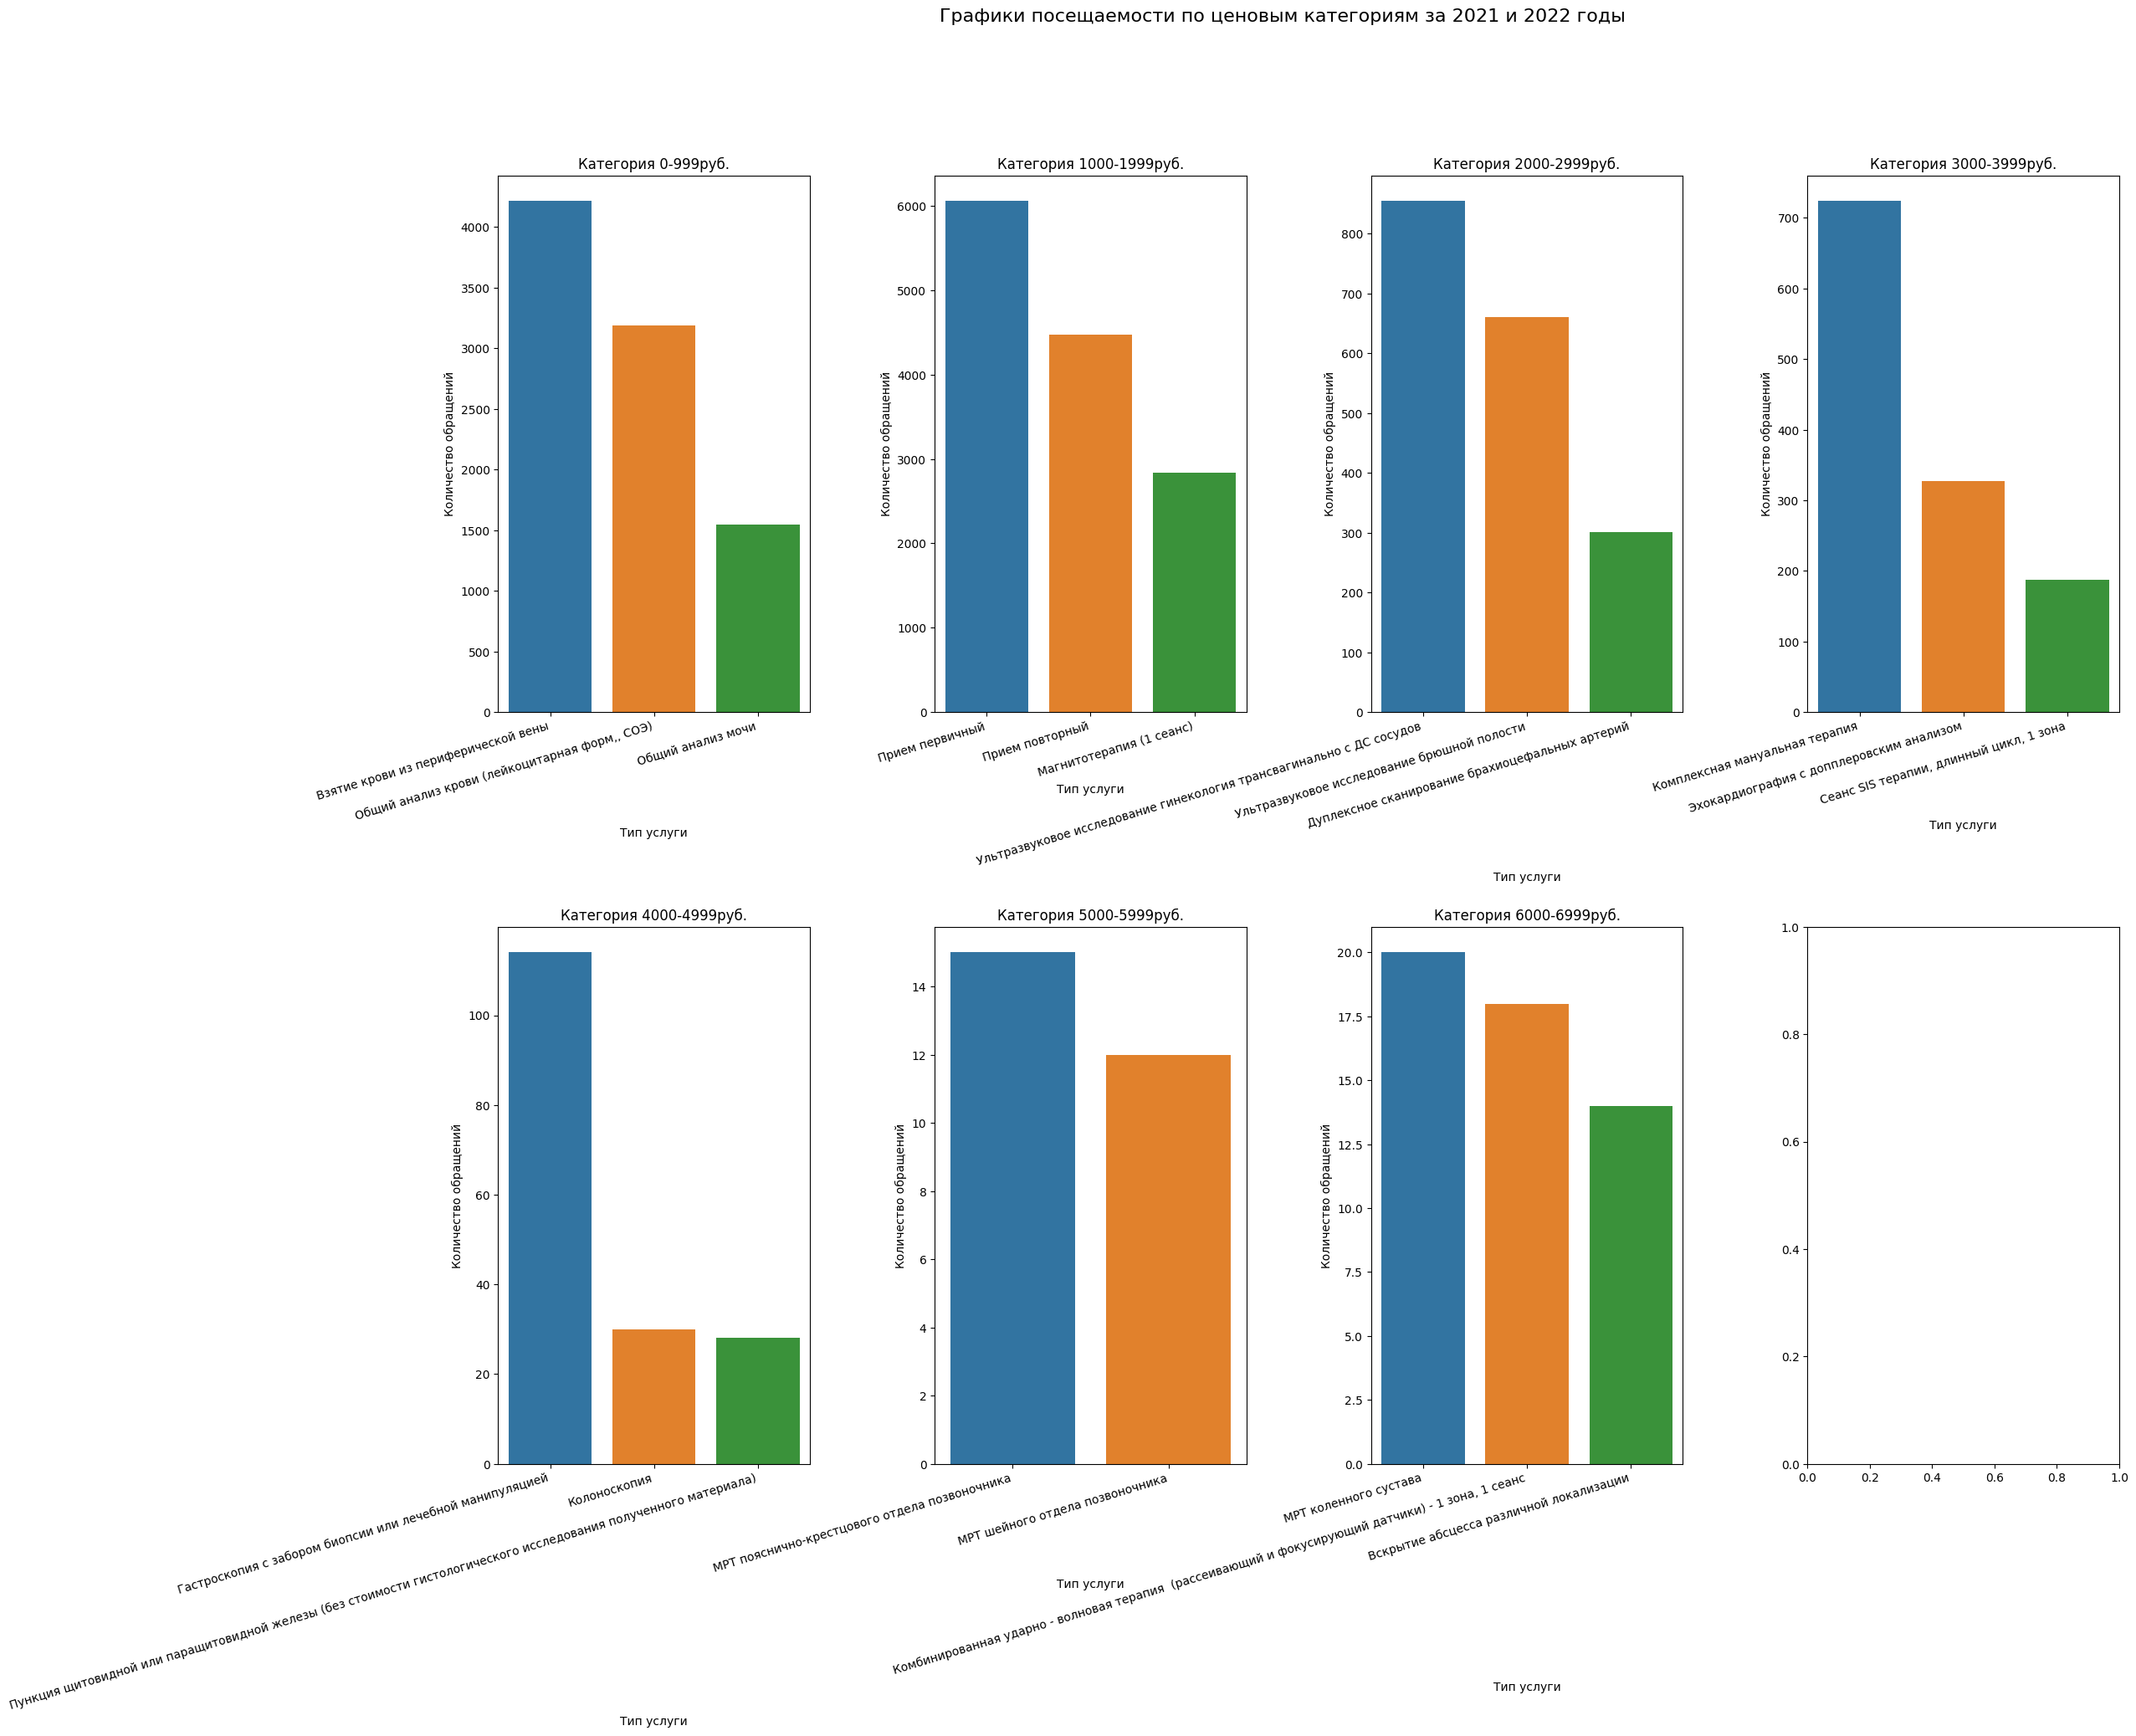

In [45]:
create_bars(4, df_top_3, '2021 и 2022 годы')

На представленных графиках можно заметить, что лидируют услуги в ценовой категории 1000-1999 руб., также популярностью пользуются услуги в категориии до 999 руб., в меньшей степени от 2000 до 3999 руб., а в еще меньшей степени свыше 4000 руб. В рамках анализа было принято решение избавиться от категорий, событирующих менее 10 обращений: учитывая объем данных и отрасль исследования, это слишком небольшое количество клиентов для проведения анализа, при этом графиков будет создано еще больше, что может навредить проводимому исследованию. Анализировать наименования услуг в рамках каждой категории сейчас бессмысленно, так как данные представлены за оба года и в перечне услуг были изменения, поэтому сделаем срез по 2021 и 2022 годам по отдельности и построим аналогичные графики.

In [46]:
# создадим датасет с ТОП-3 по каждой категории за 2021 год
df_top_3_2021 = top_n_per_category(df.query('year == 2021'), 'price_category', 'service_name', 'record_id', n=3)\
                                  .reset_index(drop=True)

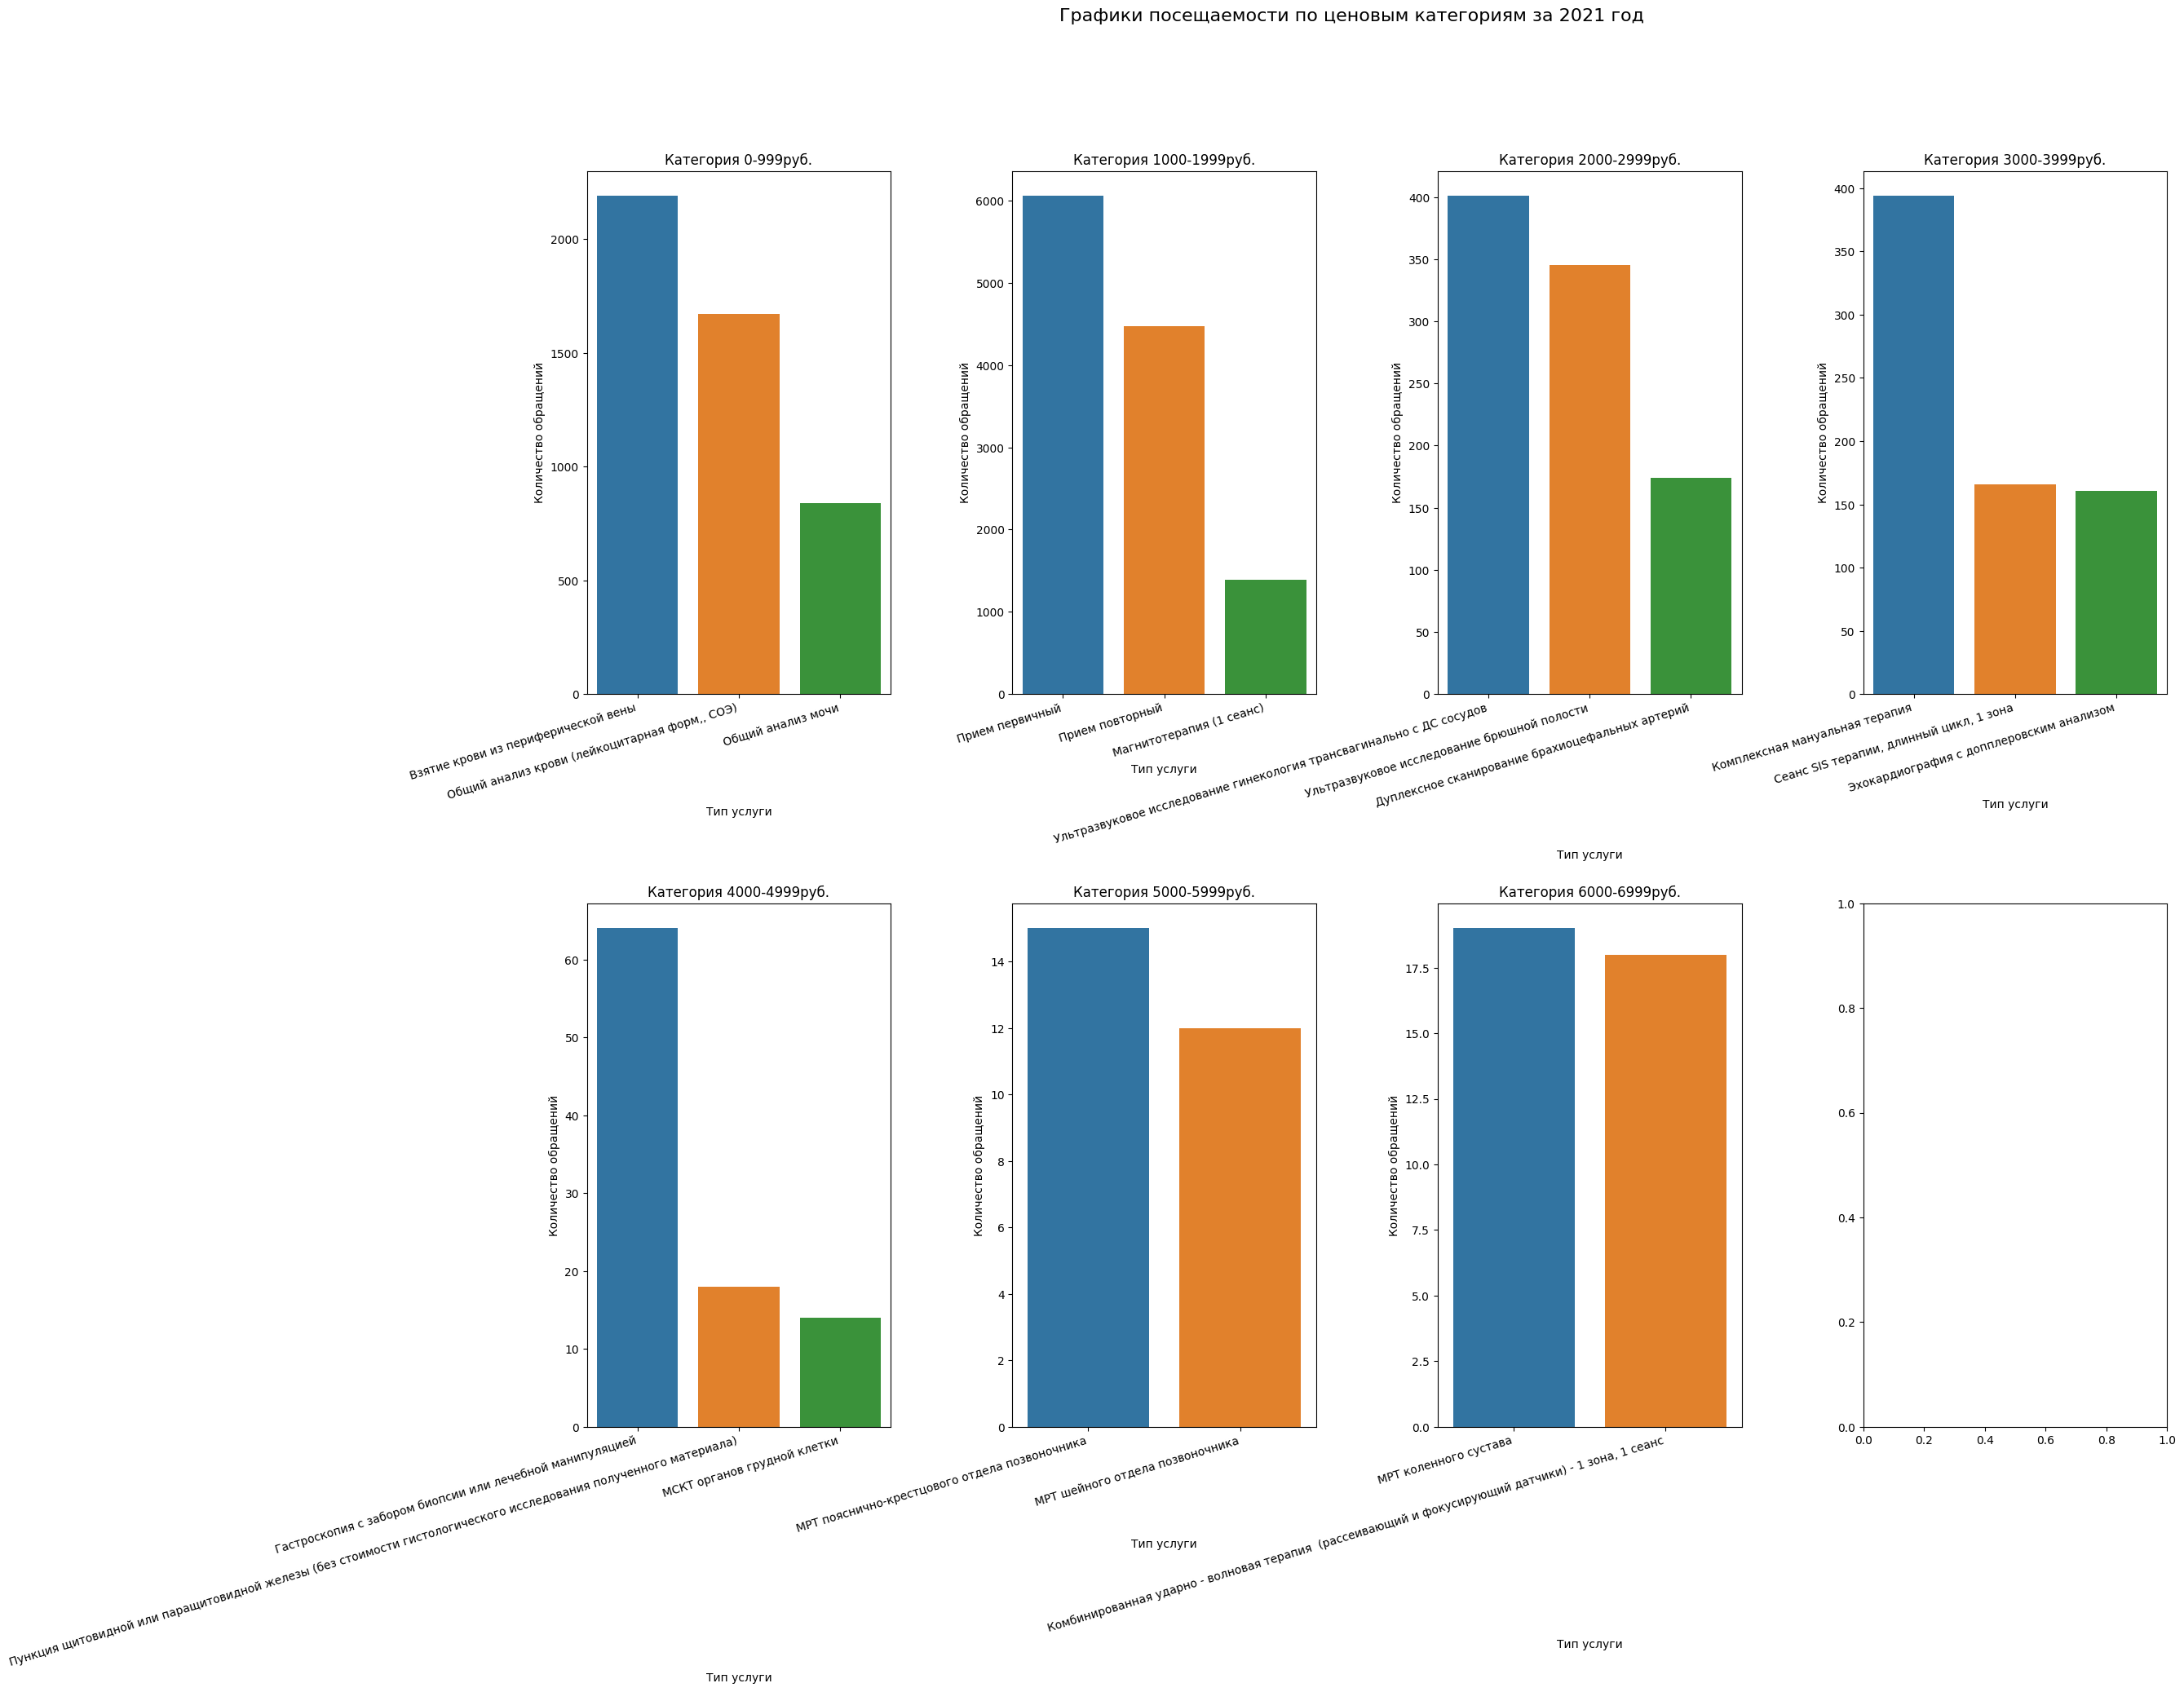

In [47]:
# построим графики
create_bars(4, df_top_3_2021, '2021 год')

Тенденция посещаемости по категориям сохранятеся: при этом наиболее популярными в рамках категории от 1000 до 1999 руб. являются первичные и повторные приемы, а также магнитотерапия. В категории до 999 руб. лидируют наиболее стандартные анализа - сбор и анализ крови, а также общий анализ мочи. В категории до 2999 доминируют ультразвуковые исследования (гинекология и гастроэнтрология), а также дупрексное сканирование артерий. Наконец, в категории до от 3000 до 3999 руб. лидируют комплексная мануальная терапия, сеанс SIS терапии длинного цикла и эхокардиография с доплеровским анализом. Рассмотрим аналогичный график за 2022 год.

In [48]:
# создадим датасет с ТОП-3 по каждой категории за 2022 год
df_top_3_2022 = top_n_per_category(df.query('year == 2022'), 'price_category', 'service_name', 'record_id', n=3)\
                                  .reset_index(drop=True)

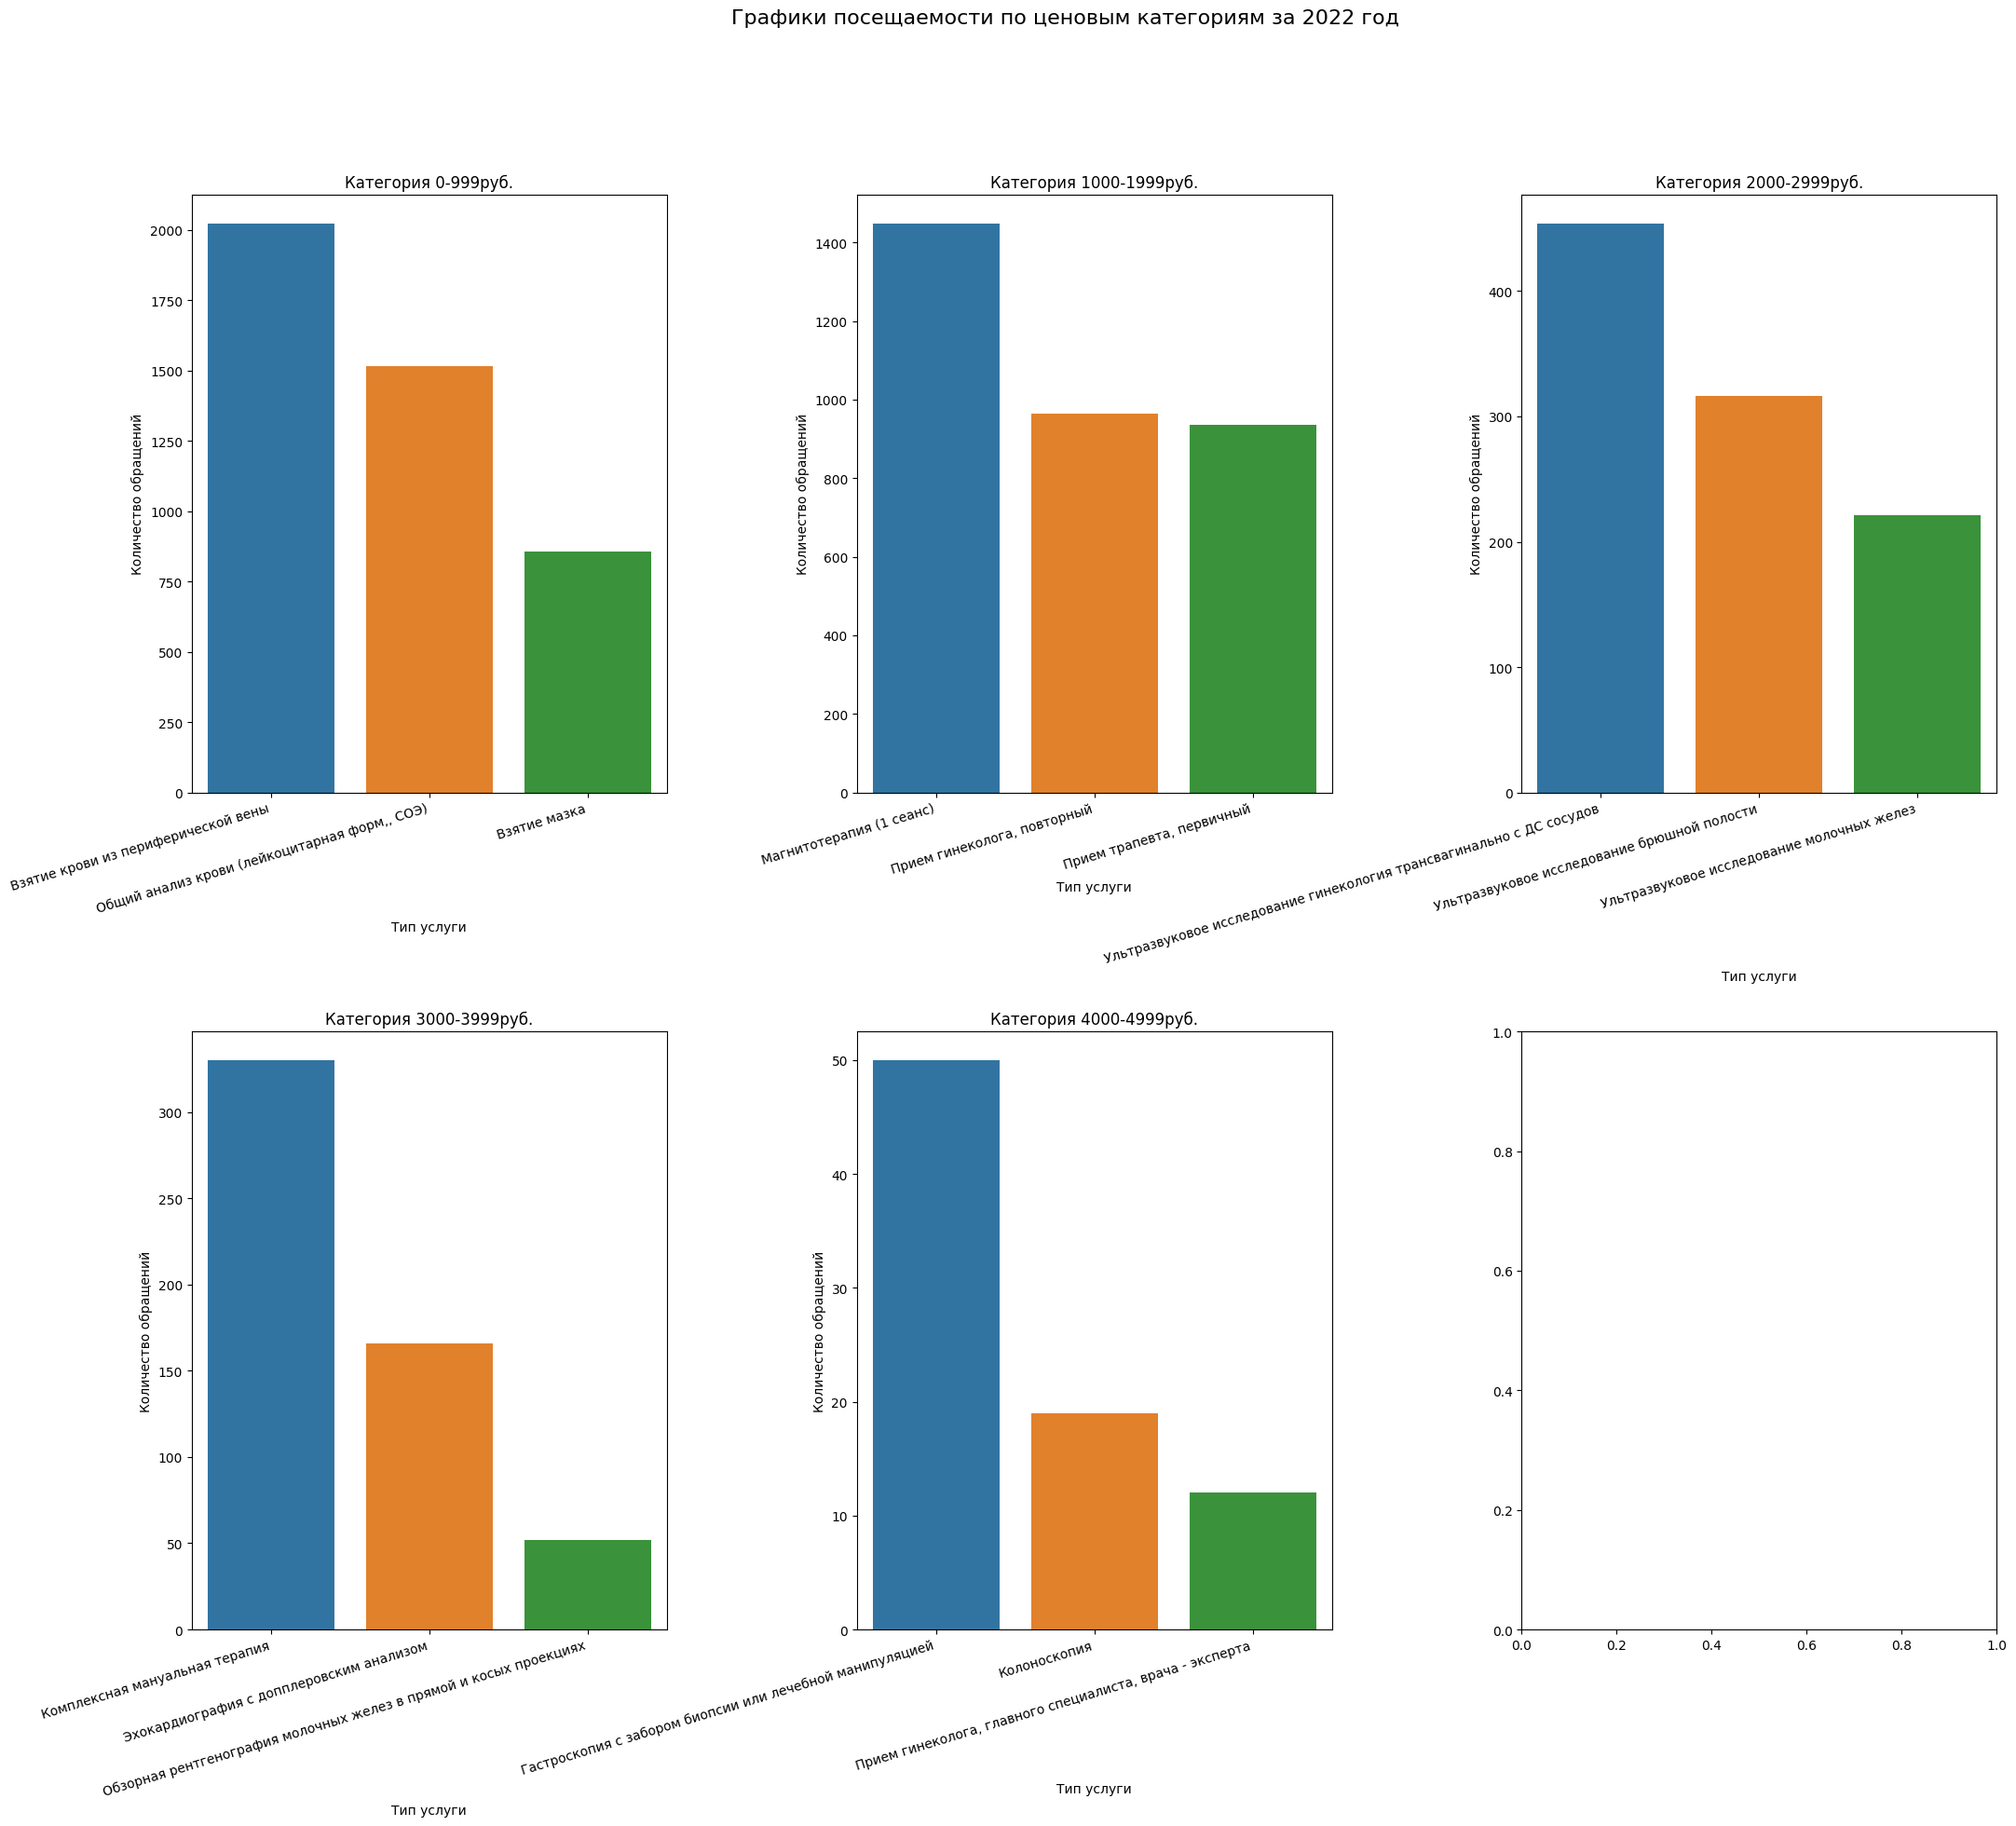

In [49]:
# построим графики
create_bars(3, df_top_3_2022, '2022 год')

Тенденция сохраняется с небольшими изменениями: во-первых, категорию 1000-1999 руб. необходимо рассмотреть отдельно - сейчас все посещения распределены между врачами разных профилей, чего не было в 2021 году. Рассмотрим среднюю стоимость врачей по профилям за 2022 год.

In [50]:
# сгруппируем данные и вычислим сумму, среднее значение и медиану
df_grouped_by_prof_and_avg_bill = df.query('year == 2022 and service_name.str.contains("первичный")').groupby\
                                  ('service_name')['service_amount'].agg(['sum', 'mean', 'median']).sort_values(by='sum', \
                                  ascending=False).reset_index()
df_grouped_by_prof_and_avg_bill['percent'] = (df_grouped_by_prof_and_avg_bill['sum'] / df_grouped_by_prof_and_avg_bill['sum'] \
                                              .sum()) * 100

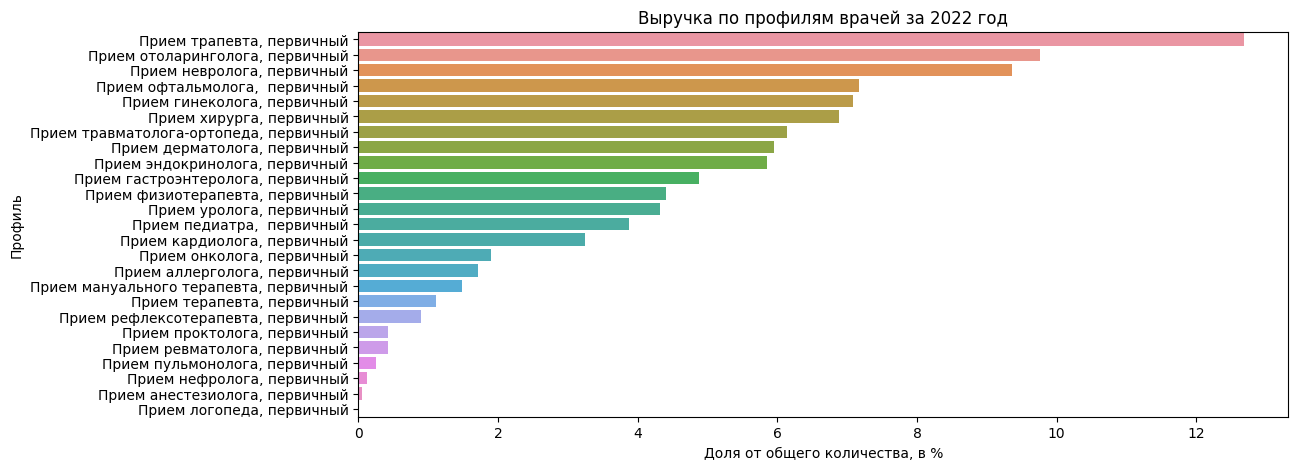

In [51]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_prof_and_avg_bill, x='percent', y='service_name', orient='h')
plt.title('Выручка по профилям врачей за 2022 год')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

На графике можно увидеть, что более 12% от выручки клиника получает от первичных приемов терапетов (что вполне логично, так как это наиболее широкопрофильный специалист). Чуть более 10% - отоларинголога, в районе 9% - невролога, 7% - офтальмолога, гинеколога и хирурга. Наименьший вклад в выручку оказывают логод, анастезиолог, нефролог, пульмнолог, ревматолог и проктолог - менее 1%. Рассмотрим также средние и медианные значения AOV по профилям врачам, чтобы оценить равномерность ценообразования.

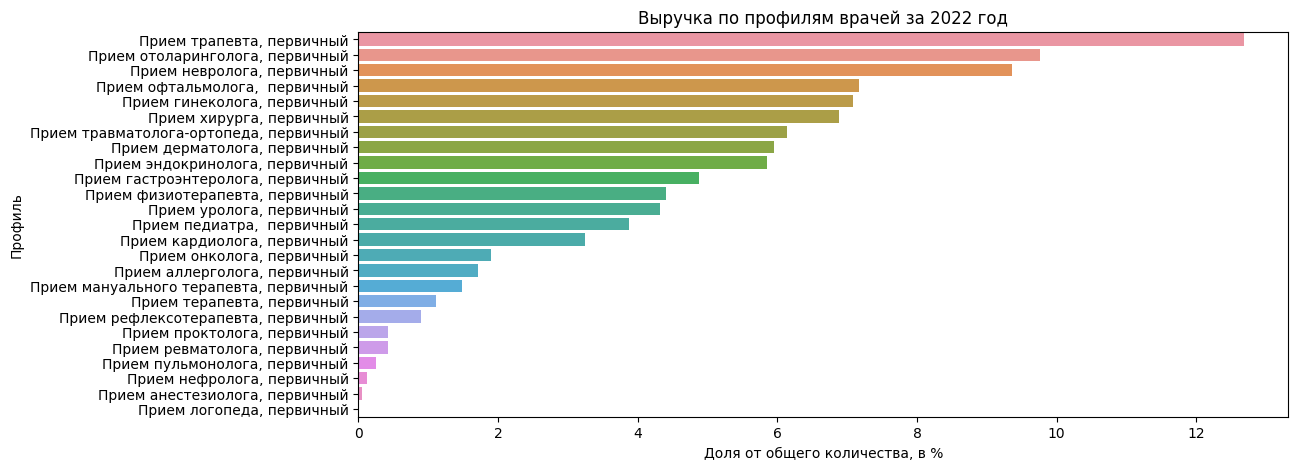

In [52]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_prof_and_avg_bill, x='percent', y='service_name', orient='h')
plt.title('Выручка по профилям врачей за 2022 год')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

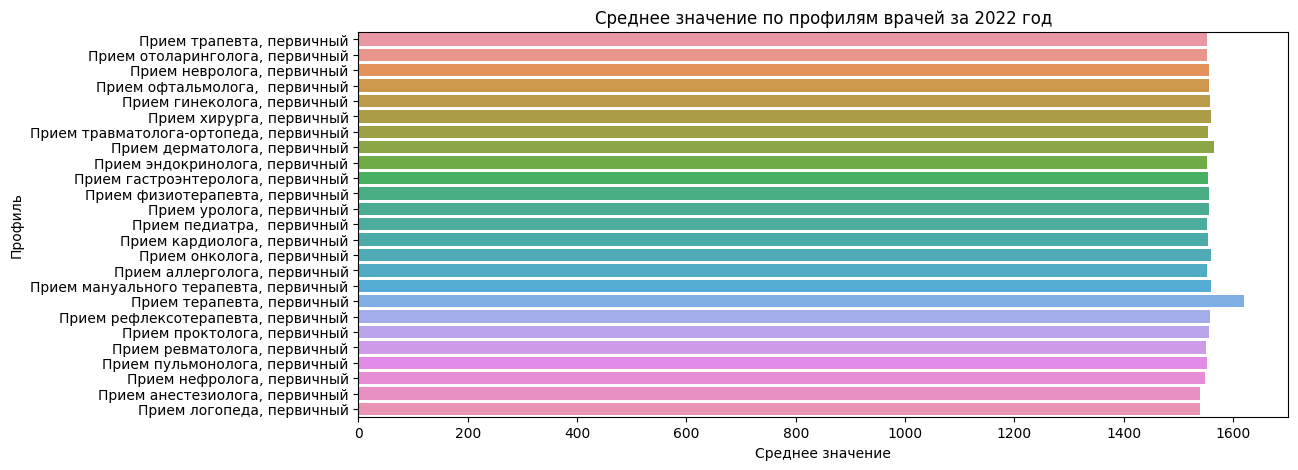

In [53]:
# построим графики по средним и медианным значениям
for metric in ['mean', 'median']:
    label_dict = {'mean': 'Среднее значение', 'median': 'Медиана'}
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df_grouped_by_prof_and_avg_bill, x=metric, y='service_name', orient='h')
    plt.title('{} по профилям врачей за 2022 год'.format('Среднее значение' if metric == 'mean' else 'Медианное значение'))
    plt.xlabel('{}'.format('Среднее значение' if metric == 'mean' else 'Медианное значение'))
    plt.ylabel('Профиль')

    plt.show()

Видим, что средняя цена - схожа, медиана, в принципе, едина, что указывает на то, что ценовая политика для всех профилей врачей в рамках первичных приемов - одинакова. Единственное - выбивается, терапевт, рассмотрим этот срез данных более подробно.

In [54]:
df.query('service_name.str.contains("трапевт") and service_amount > 2000')

record_id service_date               service_name  service_amount  \
47776  31996579603   2022-01-04  Прием трапевта, первичный            2950   

       service_number  insured sex_id  age_for_service_date  year age_group  \
47776               1   682378    2.0                    37  2022     30-39   

      price_category  
47776      2000-2999

В данных присутствует всего лишь одна запись, ценообразование по которой определить представляется проблематичным. Проведем аналогичный анализ по повторным посещениям.

In [55]:
# сгруппируем данные и вычислим сумму, среднее значение и медиану
df_grouped_by_prof_and_avg_bill_second = df.query('year == 2022 and service_name.str.contains("повторный")').groupby\
                                  ('service_name')['service_amount'].agg(['sum', 'mean', 'median']).sort_values(by='sum', \
                                  ascending=False).reset_index()
df_grouped_by_prof_and_avg_bill_second['percent'] = (df_grouped_by_prof_and_avg_bill_second['sum'] /
                                                     df_grouped_by_prof_and_avg_bill_second['sum'].sum()) * 100

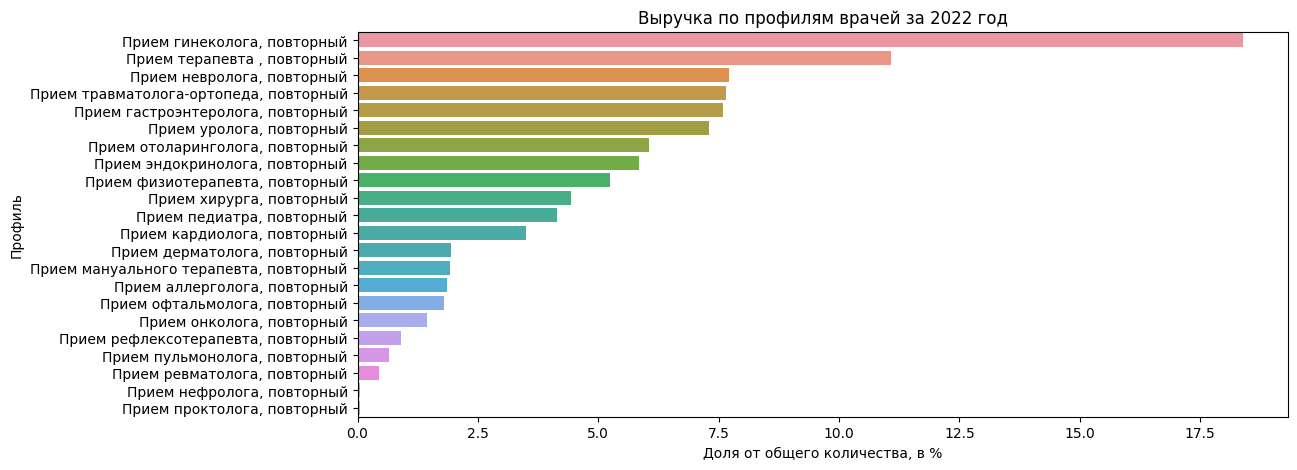

In [56]:
# построим график
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_prof_and_avg_bill_second, x='percent', y='service_name', orient='h')
plt.title('Выручка по профилям врачей за 2022 год')
plt.xlabel('Доля от общего количества, в %')
plt.ylabel('Профиль')

plt.show()

Более 17.5% выручки от повторных посещений поступает от приема гинеколога, что указывает на то, что женщины в большей степени склонны к повторным обращениям в клинику (а стоимость привлечения нового клиента, как правило, обычно дороже, чем стоимость удержания текущего, что непосредненно влияет на прибыль компании). Кроме того, более 10% выручки поступают от повторного посещений терапевта, а около 8% - от невролога, травматолога-ортопеда, гастроэнтеролога и уролога. В меньшей степени выручка от повторных обращений образуется от приемов проктолога, нефролога, ревматолога, пульмонолога и рекфлексолога.

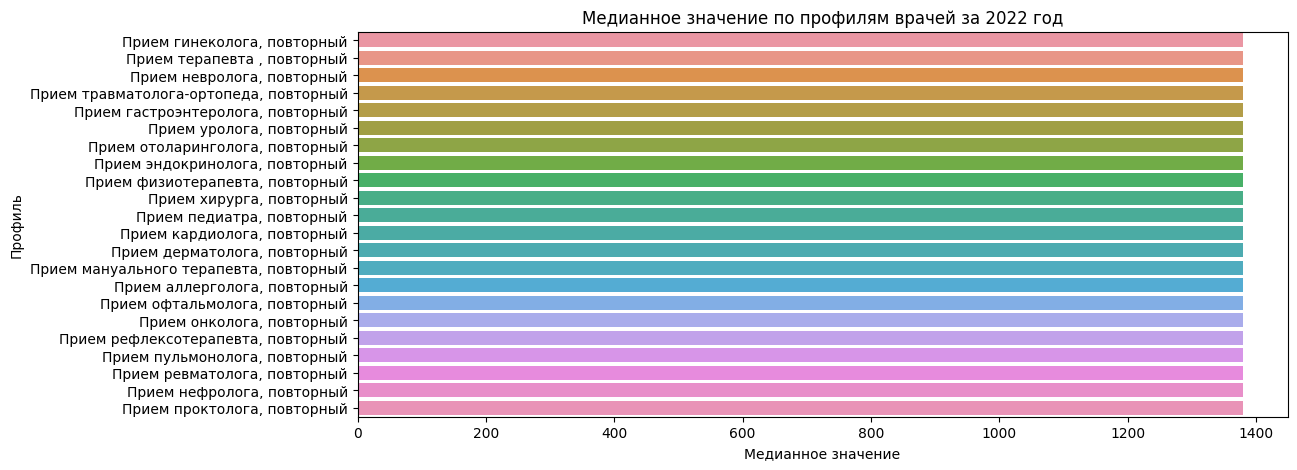

In [57]:
# построим графики по средним и медианным значениям
for metric in ['mean', 'median']:
    label_dict = {'mean': 'Среднее значение', 'median': 'Медиана'}
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df_grouped_by_prof_and_avg_bill_second, x=metric, y='service_name', orient='h')
    plt.title('{} по профилям врачей за 2022 год'.format('Среднее значение' if metric == 'mean' else 'Медианное значение'))
    plt.xlabel('{}'.format('Среднее значение' if metric == 'mean' else 'Медианное значение'))
    plt.ylabel('Профиль')

    plt.show()

Среднее и медианное значение еще более равномерны, чем при анализе первичных приемов, дополним анализ расчетом показателей описательной статисики.

Наконец, рассчитаем статистические показатели по срезу с профилями врачей, чтобы определить равномерность распределения данных.

In [58]:
# делаем срез и рассчитываем показатели описательной статистики за 2022 год по первичным посещениям
df.query('year == 2022 and service_name.str.contains("первичный")')['service_amount'].describe()

count    7361.000000
mean     1555.952316
std        43.195593
min      1350.000000
25%      1540.000000
50%      1540.000000
75%      1540.000000
max      3350.000000
Name: service_amount, dtype: float64

В целом, данные распределены достаточно равномерно, на что указывает относительно низкий показатель среднеквадратического отклонения: так, посещение каждого врача отличается от среднего значения в 1555 руб. на 43 руб., при этом минимальное значение составляет 1350 руб., а максимальное - 3350 руб. В целом, подобное уже было озвучено в рамках анализа боксплотов, но после проведенного анализа можно говорить о том, что данные распределены равномерно. Далее перейдем к анализу гипотез, связанных с изменением цены в 2022 по отношению к 2021 году.

In [59]:
# делаем срез и рассчитываем показатели описательной статистики за 2022 год по повторным посещениям
df.query('year == 2022 and service_name.str.contains("повторный")')['service_amount'].describe()

count    5242.000000
mean     1393.666539
std        30.047120
min      1380.000000
25%      1380.000000
50%      1380.000000
75%      1380.000000
max      2250.000000
Name: service_amount, dtype: float64

Повторные приемы, в среднем, оказываются дешевле, чем первичные, что может быть частью программы лояльности клиники. Кроме того, показатель среднеквадратического отклонения еще меньше, что указывает на более-менее однородный характер данных. Далее перейдем к анализу гипотез, связанных с изменением цены в 2022 по отношению к 2021 году.

#### 4.3.2. Анализ ценовых факторов в разрезе поло-возрастных показателей

Первой гипотезой проводимого исследования является то, что цена отличается в зависимости пола и возраста клиентов клиники. Для проверки данной гипотезы рассмотрим показатель AOV на каждый пол, возраст, а также на сочетаниях обоих признаков. Начнем с характеристики пола.

In [60]:
# сгруппируем данные по полу и рассчитаем AOV
df_grouped_by_sex_aov = df.groupby('sex_id')['service_amount'].agg(['sum', 'mean', 'median']).reset_index()
df_grouped_by_sex_aov

sex_id       sum         mean  median
0            1.0  38047323  1169.104074  1155.0
1            2.0  61479095  1164.288596  1150.0
2  пол не указан     21915  1043.571429  1313.0

In [61]:
# проанализируем несколько выборок для того, чтобы убедиться, что 1 - мужчины, а 2 - женщины (по типам услуг)
df.sample(5)

record_id service_date  \
9918   30620986803   2021-04-07   
47     30268161703   2021-01-05   
58217  32327268803   2022-03-28   
53072  32112861903   2022-02-10   
55875  32327031503   2022-03-14   

                                            service_name  service_amount  \
9918         Ультразвуковое исследование брюшной полости            2100   
47     Ультразвуковое исследование почек и надпочечников            1995   
58217                                        Трансферрин             580   
53072                     Прием эндокринолога, первичный            1540   
55875      Лекарственный электрофорез (1 сеанс) (2 поля)             940   

       service_number  insured sex_id  age_for_service_date  year age_group  \
9918                1   490589    2.0                     6  2021       0-9   
47                  1   418179    1.0                    40  2021     30-39   
58217               1   716116    2.0                    23  2022     20-29   
53072               1   822718    1.0                    59  2022     50-59   
55875               1   716123    2.0                    26  2022     20-29   

      price_category  
9918       2000-2999  
47         1000-1999  
58217          0-999  
53072      1000-1999  
55875          0-999

Исходя из информации в свободной таблице можно заметить, что женщины (id №2) несмотря на практически идентичный средний и медианный чеки оставили в больнице за 2 года на 61% больше денежных средств, чем мужчины. Проанализируем также количество женщин по отношению к мужчинам.

In [62]:
print('Всего обратилось мужчин за 2 года:', df.query('sex_id == 1')['record_id'].count())
print('Всего обратилось женщин за 2 года:', df.query('sex_id == 2')['record_id'].count())
print('Соотношение мужчин к женщинам составляет:', (df.query('sex_id == 1')['record_id'].count() /
      df.query('sex_id == 2')['record_id'].count()).round(2))

Всего обратилось мужчин за 2 года: 32544
Всего обратилось женщин за 2 года: 52804
Соотношение мужчин к женщинам составляет: 0.62


Так, несмотря на отсутствие стратегии дифференции по полу в области ценообразования (AOV практически идентичны), женщин посетило клинику на 38% больше, чем мужчин, за 2 года, что сказывается на генерации ими выручки. Проанализируем аналогичные показатели за каждый год по отдельности.

In [63]:
# сгруппируем данные по полу и рассчитаем AOV за 2021 год
df_grouped_by_sex_aov_2021 = df.query('year == 2021').groupby('sex_id').agg({'record_id': 'count', 'service_amount': 'sum',
                                                                       'service_amount': ['sum', 'mean', 'median']})\
                                                                        .reset_index()

df_grouped_by_sex_aov_2021.columns = ['_'.join(col).strip() for col in df_grouped_by_sex_aov_2021.columns.values]

df_grouped_by_sex_aov_2021['count_perc'] = (df_grouped_by_sex_aov_2021['record_id_count'] /
                                           df_grouped_by_sex_aov_2021['record_id_count'].sum()) * 100

df_grouped_by_sex_aov_2021['rev_perc'] = (df_grouped_by_sex_aov_2021['service_amount_sum'] /
                                           df_grouped_by_sex_aov_2021['service_amount_sum'].sum()) * 100

df_grouped_by_sex_aov_2021

sex_id_  record_id_count  service_amount_sum  service_amount_mean  \
0            1.0            17362            19986696          1151.174749   
1            2.0            27009            30553060          1131.217742   
2  пол не указан               21               21915          1043.571429   

   service_amount_median  count_perc   rev_perc  
0                 1134.0   39.110651  39.529342  
1                 1092.0   60.842044  60.427315  
2                 1313.0    0.047306   0.043343

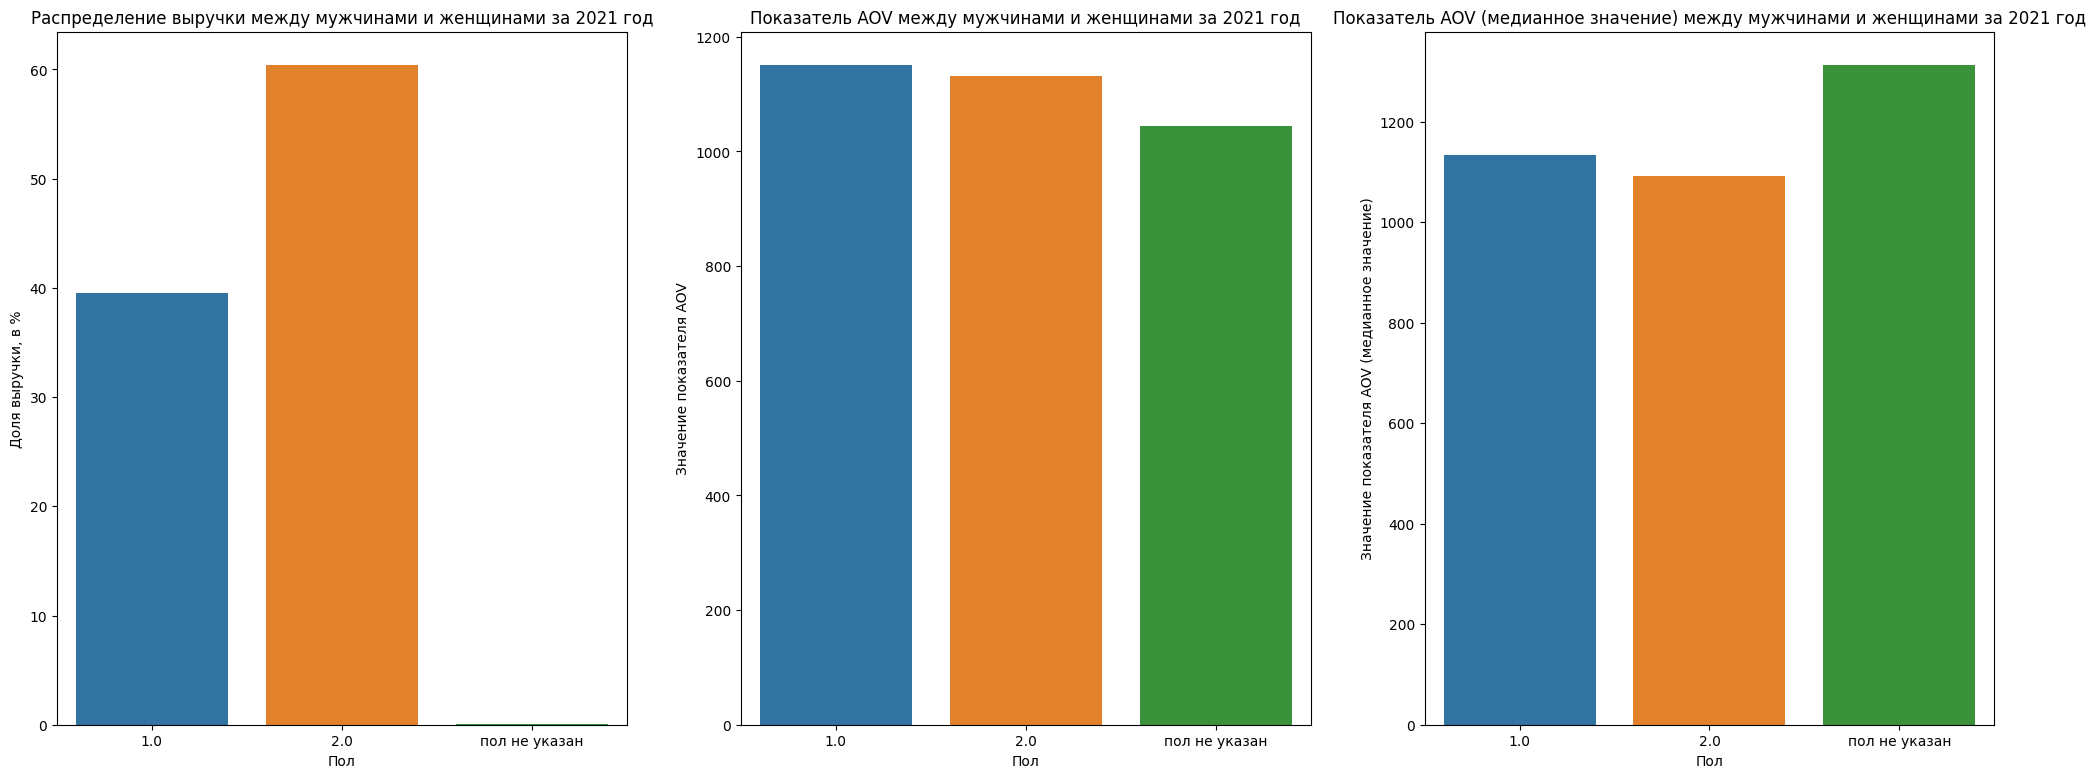

In [64]:
# построим графики
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='rev_perc', ax=axes[0])
ax1.set_title('Распределение выручки между мужчинами и женщинами за 2021 год')
ax1.set_xlabel('Пол')
ax1.set_ylabel('Доля выручки, в %')

ax2 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='service_amount_mean', ax=axes[1])
ax2.set_title('Показатель AOV между мужчинами и женщинами за 2021 год')
ax2.set_xlabel('Пол')
ax2.set_ylabel('Значение показателя AOV')

ax3 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='service_amount_median', ax=axes[2])
ax3.set_title('Показатель AOV (медианное значение) между мужчинами и женщинами за 2021 год')
ax3.set_xlabel('Пол')
ax3.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

Несмотря на то, что у мужчин, в среднем, чуть более высокий средний чек, клиентов женщин у клиники оказывается больше, что влияет напрямую на показатель выручки. В 2021 году средний чек мужчин составил 1151 руб., а женщин - 1131 руб., медианные значения - 1134 руб. и 1092 руб., соответственно. При этом женщины приносят в 1.5 больше выручки, чем мужчины. Проведем аналогичный анализ за 2022 год.

In [65]:
# сгруппируем данные по полу и рассчитаем AOV за 2022 год
df_grouped_by_sex_aov_2021 = df.query('year == 2022').groupby('sex_id').agg({'record_id': 'count', 'service_amount': 'sum',
                                                                       'service_amount': ['sum', 'mean', 'median']})\
                                                                        .reset_index()

df_grouped_by_sex_aov_2021.columns = ['_'.join(col).strip() for col in df_grouped_by_sex_aov_2021.columns.values]

df_grouped_by_sex_aov_2021['count_perc'] = (df_grouped_by_sex_aov_2021['record_id_count'] /
                                           df_grouped_by_sex_aov_2021['record_id_count'].sum()) * 100

df_grouped_by_sex_aov_2021['rev_perc'] = (df_grouped_by_sex_aov_2021['service_amount_sum'] /
                                           df_grouped_by_sex_aov_2021['service_amount_sum'].sum()) * 100

df_grouped_by_sex_aov_2021

sex_id_  record_id_count  service_amount_sum  service_amount_mean  \
0      1.0            15182            18060627          1189.607891   
1      2.0            25795            30926035          1198.915875   

   service_amount_median  count_perc   rev_perc  
0                 1190.0   37.050052  36.868458  
1                 1200.0   62.949948  63.131542

In [66]:
# построим графики
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='rev_perc', ax=axes[0])
ax1.set_title('Распределение выручки между мужчинами и женщинами за 2021 год')
ax1.set_xlabel('Пол')
ax1.set_ylabel('Доля выручки, в %')

ax2 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='service_amount_mean', ax=axes[1])
ax2.set_title('Показатель AOV между мужчинами и женщинами за 2021 год')
ax2.set_xlabel('Пол')
ax2.set_ylabel('Значение показателя AOV')

ax3 = sns.barplot(data=df_grouped_by_sex_aov_2021, x='sex_id_', y='service_amount_median', ax=axes[2])
ax3.set_title('Показатель AOV (медианное значение) между мужчинами и женщинами за 2021 год')
ax3.set_xlabel('Пол')
ax3.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

Женщин снова оказывается больше - в районе 37%, при этом показатели среднего и медианного чека более схожи: у мужчин они составляют 1189 руб. и 1190 руб., а у женщин - 1198 руб. и 1200 руб., соответственно. Разница незначительная, но учитывая, что женщин снова оказывается больше, это необходимо принимать во внимание: вполне вероятно, что женщины в большей степени склонны к походам в клинику, чем мужчины. Рассмотрим также распределение по полу и возрасту.

In [67]:
# сгруппируем данные по полу и возрасту и рассчитаем AOV за 2021 год
df_grouped_by_sex_age_aov_2021 = df.query('year == 2021').groupby(['sex_id', 'age_group']).agg({'record_id': 'count', \
                                                     'service_amount': 'sum', 'service_amount': ['sum', 'mean', \
                                                     'median']}).reset_index()

df_grouped_by_sex_age_aov_2021.columns = ['_'.join(col).strip() for col in df_grouped_by_sex_age_aov_2021.columns.values]

df_grouped_by_sex_age_aov_2021['count_perc'] = (df_grouped_by_sex_age_aov_2021['record_id_count'] /
                                           df_grouped_by_sex_age_aov_2021['record_id_count'].sum()) * 100

df_grouped_by_sex_age_aov_2021['rev_perc'] = (df_grouped_by_sex_age_aov_2021['service_amount_sum'] /
                                           df_grouped_by_sex_age_aov_2021['service_amount_sum'].sum()) * 100

In [68]:
# построим график выручки за 2021 год
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_sex_age_aov_2021, x='age_group_', y='rev_perc', hue='sex_id_')
plt.title('Распределение выручки между мужчинами и женщинами разных возрастов за 2021 год')
plt.xlabel('Возраст')
plt.ylabel('Доля выручки, в %')

plt.show()

На графиках видно, что распределение долей выручки от общего количества мужчин схоже с аналогичным распределением женщин: наибольшее количество выручки поступают от мужчин и женщин в возрасте 20-49 лет, наименьшее - 10-19 и от 50 и выше. При этом значения на графике женщин больше: это объясняется тем, что они, в целом, тратят больше, чем мужчины, что уже было выяснено ранее. Рассмотрим аналогичным образом показатель AOV в разбивке по полу и возрасту.

In [69]:
# построим графики по средним и медианным значениям за 2021 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_sex_age_aov_2021, x='age_group_', y='service_amount_mean', hue='sex_id_', \
                 ax=axes[0])
ax1.set_title('AOV между мужчинами и женщинами разных возрастов за 2021 год')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_sex_age_aov_2021, x='age_group_', y='service_amount_median', hue='sex_id_', \
                  ax=axes[1])
ax2.set_title('AOV (медианное значение) между мужчинами и женщинами разных возрастов за 2021 год')
ax2.set_xlabel('Возраст')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

Наибольшая величина среднего чека (а также его медианное значение) оказывается у мужчин в возрасте от 70 лет, а также у женщин в возрасте 60-69 и составляет около 1400 руб. и выше. Стоит отметить, что значения, в целом, не сильно отличаются, а наименьшим медианным значением обладают мужчины в возрасте 50-69 лет и женщины в возрасте 10-39 лет. Вполне вероятно, что рост среднего чека связан с возрастом клиентов: чем старше человек, тем более вероятно появление каких-либо заболеваний и необходимости посещения клиники. Рассмотрим аналогичные показатели за 2022 год.

In [70]:
# сгруппируем данные по полу и возрасту и рассчитаем AOV за 2022 год
df_grouped_by_sex_age_aov_2022 = df.query('year == 2022').groupby(['sex_id', 'age_group']).agg({'record_id': 'count', \
                                                     'service_amount': 'sum', 'service_amount': ['sum', 'mean', \
                                                     'median']}).reset_index()

df_grouped_by_sex_age_aov_2022.columns = ['_'.join(col).strip() for col in df_grouped_by_sex_age_aov_2022.columns.values]

df_grouped_by_sex_age_aov_2022['count_perc'] = (df_grouped_by_sex_age_aov_2022['record_id_count'] /
                                           df_grouped_by_sex_age_aov_2022['record_id_count'].sum()) * 100

df_grouped_by_sex_age_aov_2022['rev_perc'] = (df_grouped_by_sex_age_aov_2022['service_amount_sum'] /
                                           df_grouped_by_sex_age_aov_2022['service_amount_sum'].sum()) * 100

In [71]:
# построим график выручки за 2022 год
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_sex_age_aov_2022, x='age_group_', y='rev_perc', hue='sex_id_')
plt.title('Распределение выручки между мужчинами и женщинами разных возрастов за 2022 год')
plt.xlabel('Возраст')
plt.ylabel('Доля выручки, в %')

plt.show()

В целом, на графике представлена аналогичная тенденция, что и в 2021 году, поэтому можно говорить о том, что выручка по отношению к возрастным группам не изменялась. Рассмотрим значения AOV между мужчинами и женщинами разных возрастов.

In [72]:
# построим графики по средним и медианным значениям за 2022 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_sex_age_aov_2022, x='age_group_', y='service_amount_mean', hue='sex_id_', \
                 ax=axes[0])
ax1.set_title('AOV между мужчинами и женщинами разных возрастов за 2022 год')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_sex_age_aov_2022, x='age_group_', y='service_amount_median', hue='sex_id_', \
                  ax=axes[1])
ax2.set_title('AOV (медианное значение) между мужчинами и женщинами разных возрастов за 2022 год')
ax2.set_xlabel('Возраст')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

В целом, динамика по AOV аналогичная, что и в 2021 году: единственное измененение - небольшое рост среднего чека в категории мужчин от 70 до 79 лет. Таким образом, можно говорить о том, что выручка клиники зависит от пола, так как генерируется в большей степени женщинами, а также от возраста - в основном клинику посещают люди в возрасте 20-39 лет. При этом сильных изменений с точки зрения в 2022 году по отношению к 2021 обнаружено не было, как и стратегии ценовой дискриминации по отношению к какому-либо полу или возрасту на что указывают относительно равномерные показатели AOV. Далее рассмотрим гипотезу, связанную с сезонностью: вполне вероятно, что средняя стоимость лечения в разные промежутки года отличается.

#### 4.3.2. Анализ ценовых факторов в разрезе сезонности спроса

Далее рассмотрим, как меняются показатели выручки и цены в зависимости от сезонности. Для этого добавим в таблицу еще один столбец с номером квартала, чтобы в дальнейшем иметь возможность делать срезы по данному значению.

In [73]:
# добавляем столбец с номером месяца
df['quarter'] = df['service_date'].dt.quarter

Для начала проанализируем данные по сезонности за весь анализируемый период: для этого рассчитаем выручку и AOV за каждый квартал обоих годов.

In [74]:
# группируем данные по кварталу
df_grouped_by_quarter = df.groupby('quarter').agg({'record_id': 'count', 'service_amount': 'sum', 'service_amount': \
                                                   ['sum', 'mean', 'median']}).reset_index()

df_grouped_by_quarter.columns = ['_'.join(col).strip() for col in df_grouped_by_quarter.columns.values]

df_grouped_by_quarter['count_perc'] = (df_grouped_by_quarter['record_id_count'] /
                                           df_grouped_by_quarter['record_id_count'].sum()) * 100

df_grouped_by_quarter['rev_perc'] = (df_grouped_by_quarter['service_amount_sum'] /
                                           df_grouped_by_quarter['service_amount_sum'].sum()) * 100

df_grouped_by_quarter

quarter_  record_id_count  service_amount_sum  service_amount_mean  \
0         1            22113            25121919          1136.070140   
1         2            30403            35704820          1174.384765   
2         3            19426            22900334          1178.849686   
3         4            13427            15821260          1178.316824   

   service_amount_median  count_perc   rev_perc  
0                 1100.0   25.902845  25.235901  
1                 1190.0   35.613630  35.866819  
2                 1155.0   22.755333  23.004237  
3                 1150.0   15.728192  15.893044

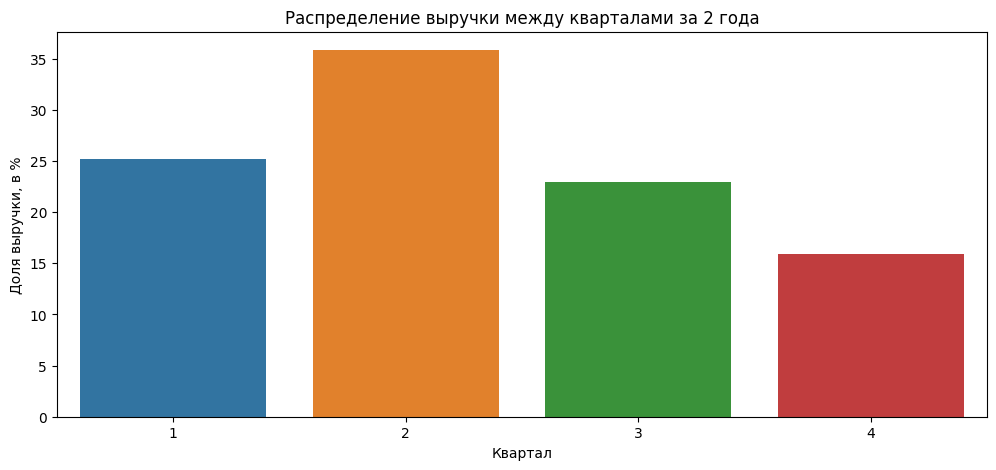

In [75]:
# построим график выручки за каждый квартал
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_quarter, x='quarter_', y='rev_perc')
plt.title('Распределение выручки между кварталами за 2 года')
plt.xlabel('Квартал')
plt.ylabel('Доля выручки, в %')

plt.show()

На графиках можно заметить, что большая часть выручки, около 35%, приходится на 2 квартал года - то есть, с апреля по июнь. Примерно в одинаковом соотношении находятся 1 и 3 кварталы - январь-март и июль-сентябрь. Меньше всего клиника зарабатывает в 4 квартал - в районе 17.5% от совокупного дохода. Вполне вероятно, что клиенты клиники в меньшей степени склонны заниматься проблемами здоровья к концу года, а во 2 квартале начинается сезон аллергических обострений + многие берут отпуска и, возможно, хотят посетить клинику перед отъездом. Рассмотрим данные по AOV.

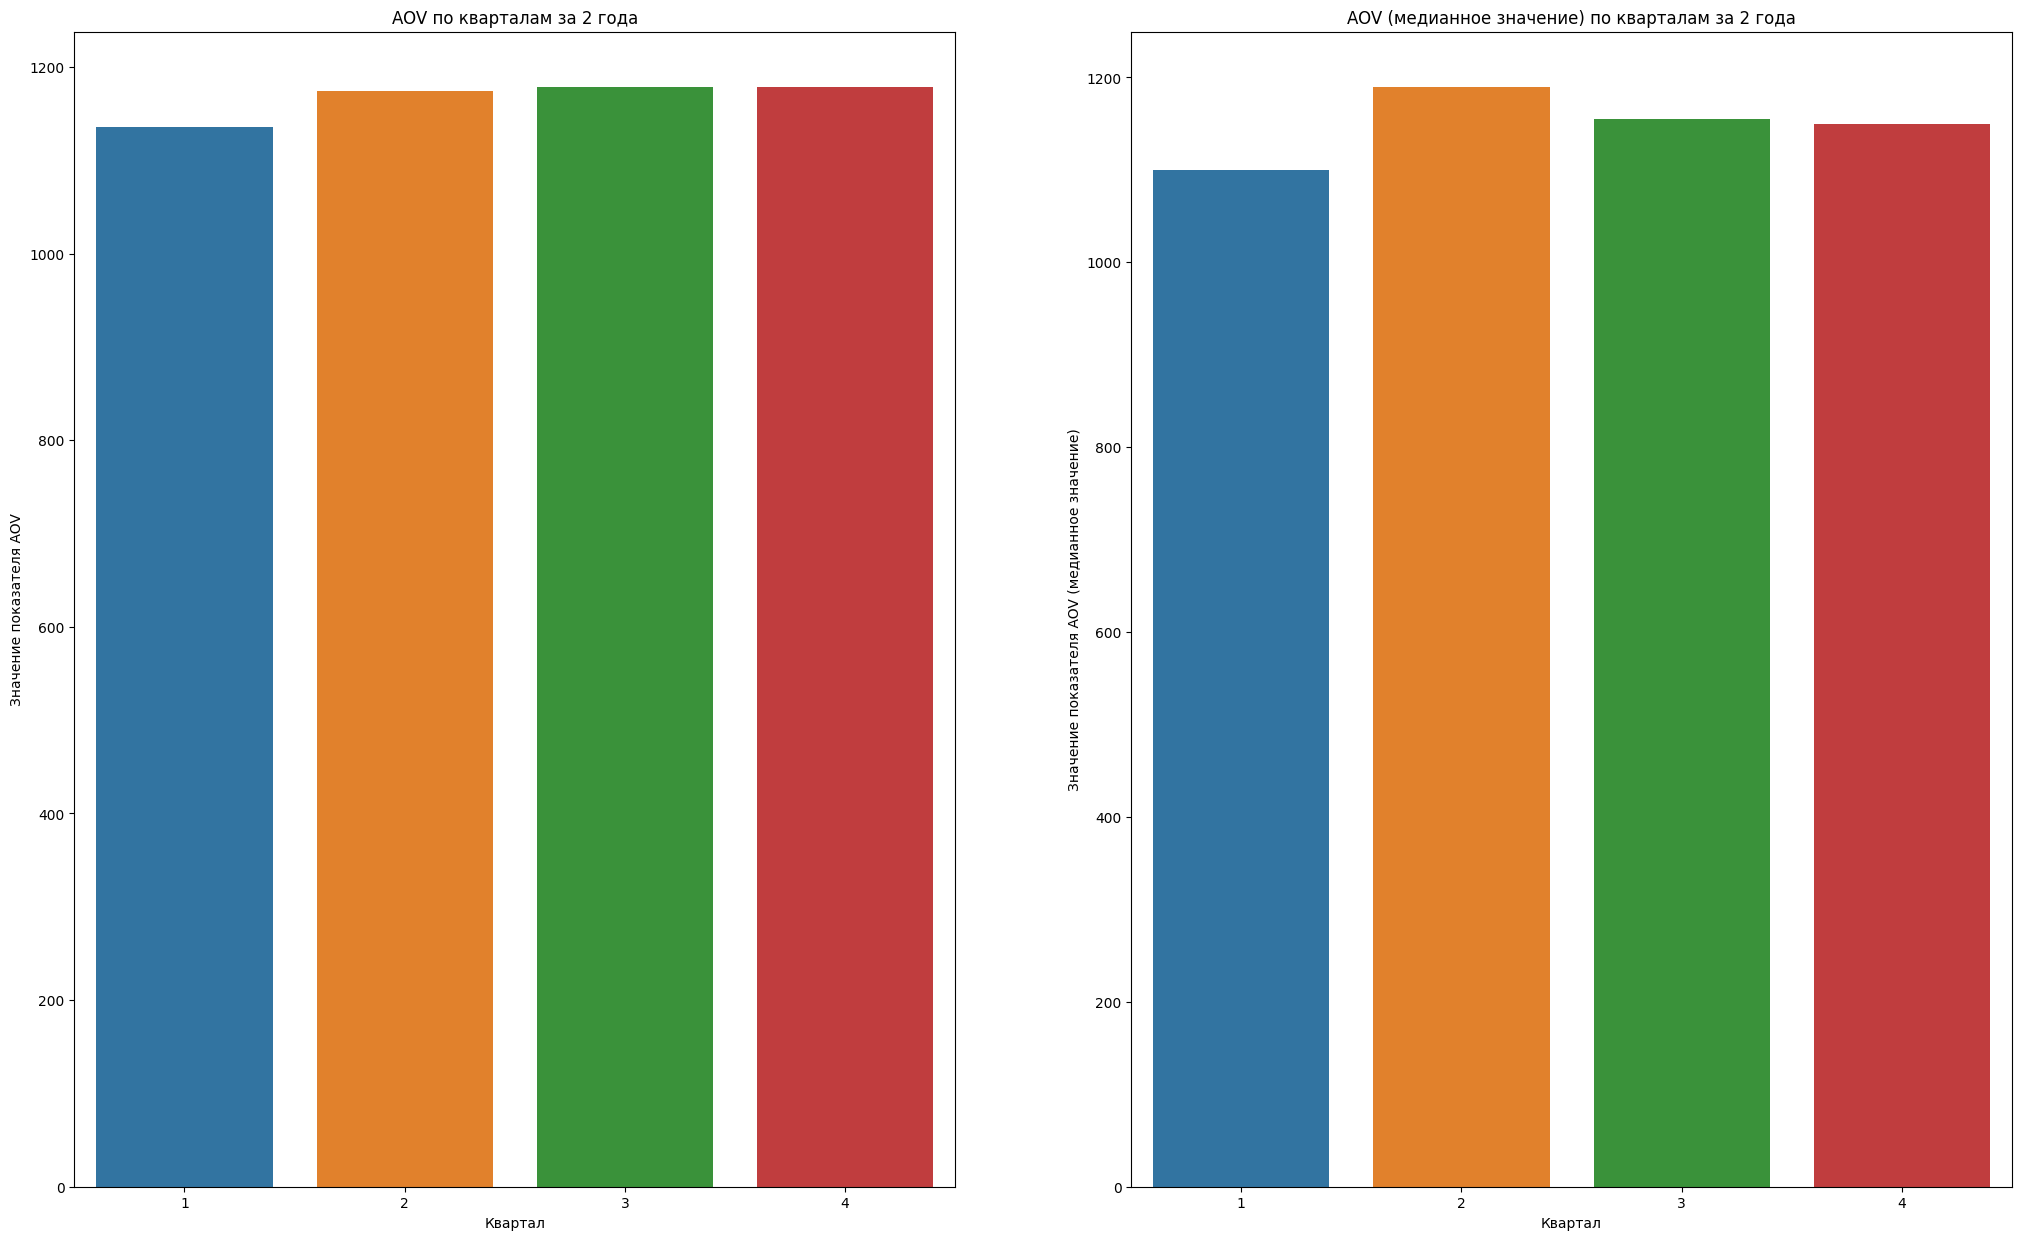

In [76]:
# построим графики по средним и медианным значениям за оба года
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_quarter, x='quarter_', y='service_amount_mean', ax=axes[0])
ax1.set_title('AOV по кварталам за 2 года')
ax1.set_xlabel('Квартал')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_quarter, x='quarter_', y='service_amount_median', ax=axes[1])
ax2.set_title('AOV (медианное значение) по кварталам за 2 года')
ax2.set_xlabel('Квартал')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

На графиках видно, что средний чек клиники практически не изменяется от сезона к сезону - медианное значение показывает, что средний чек больше во 2 и 3 кварталах, но разница не очень значительна. При этом важно отметить, что данные за 4 квартал не совсем корректные для общего анализа, так как фактически представлены только данными за 2021 год и отражают не общую картину, а только тенденции 2021 года. роанализируем изменения среднего чека по кварталам за каждый год.

In [77]:
# группируем данные по кварталу и по году
df_grouped_by_quarter_year = df.groupby(['year', 'quarter']).agg({'record_id': 'count', 'service_amount': 'sum', \
                                                                  'service_amount': \
                                                   ['sum', 'mean', 'median']}).reset_index()

df_grouped_by_quarter_year.columns = ['_'.join(col).strip() for col in df_grouped_by_quarter_year.columns.values]

df_grouped_by_quarter_year['count_perc'] = (df_grouped_by_quarter_year['record_id_count'] /
                                           df_grouped_by_quarter_year['record_id_count'].sum()) * 100

df_grouped_by_quarter_year['rev_perc'] = (df_grouped_by_quarter_year['service_amount_sum'] /
                                           df_grouped_by_quarter_year['service_amount_sum'].sum()) * 100

df_grouped_by_quarter_year

year_  quarter_  record_id_count  service_amount_sum  service_amount_mean  \
0   2021         1             7837             8572304          1093.824678   
1   2021         2            11572            13202050          1140.861562   
2   2021         3            11556            12966057          1122.019470   
3   2021         4            13427            15821260          1178.316824   
4   2022         1            14276            16549615          1159.261348   
5   2022         2            18831            22502770          1194.985396   
6   2022         3             7870             9934277          1262.296950   

   service_amount_median  count_perc   rev_perc  
0                 1050.0    9.180147   8.611198  
1                 1092.0   13.555272  13.261950  
2                 1113.0   13.536530  13.024886  
3                 1150.0   15.728192  15.893044  
4                 1150.0   16.722698  16.624703  
5                 1210.0   22.058358  22.604869  
6                 1250.0    9.218803   9.979350

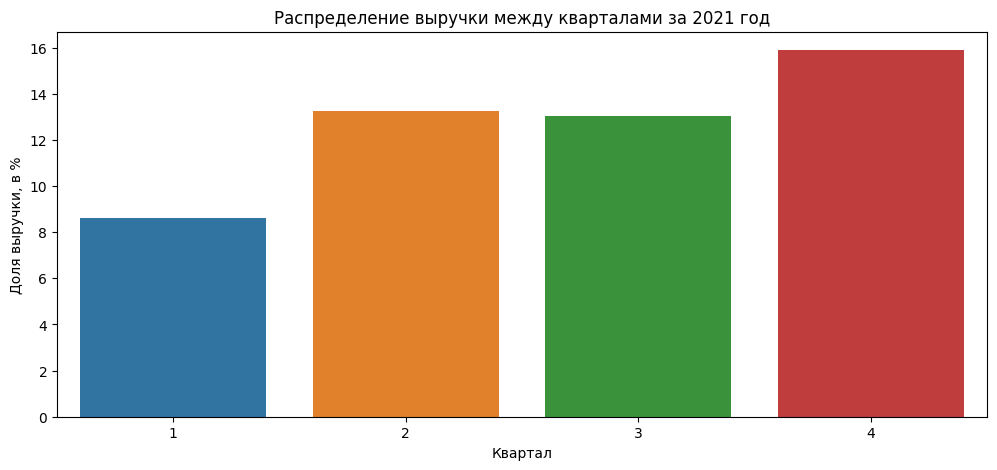

In [78]:
# построим график выручки за каждый квартал 2021 года
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2021'), x='quarter_', y='rev_perc')
plt.title('Распределение выручки между кварталами за 2021 год')
plt.xlabel('Квартал')
plt.ylabel('Доля выручки, в %')

plt.show()

Исходя из представленного графика можно сделать выводы, что ситуация в 2021 году была совершенно противоположной: наибольшая часть выручки поступала в клинику в рамках 4 квартала - в районе 16%, несколько меньше во 2 и 3 кварталах - около 13% и наименьшая доля пришлась на 1 квартал - в районе 9%. Вполне вероятно, что такая динамика связана с очередной вспышкой вируса COVID-19, особенно к концу года. Рассмотрим также значения AOV.

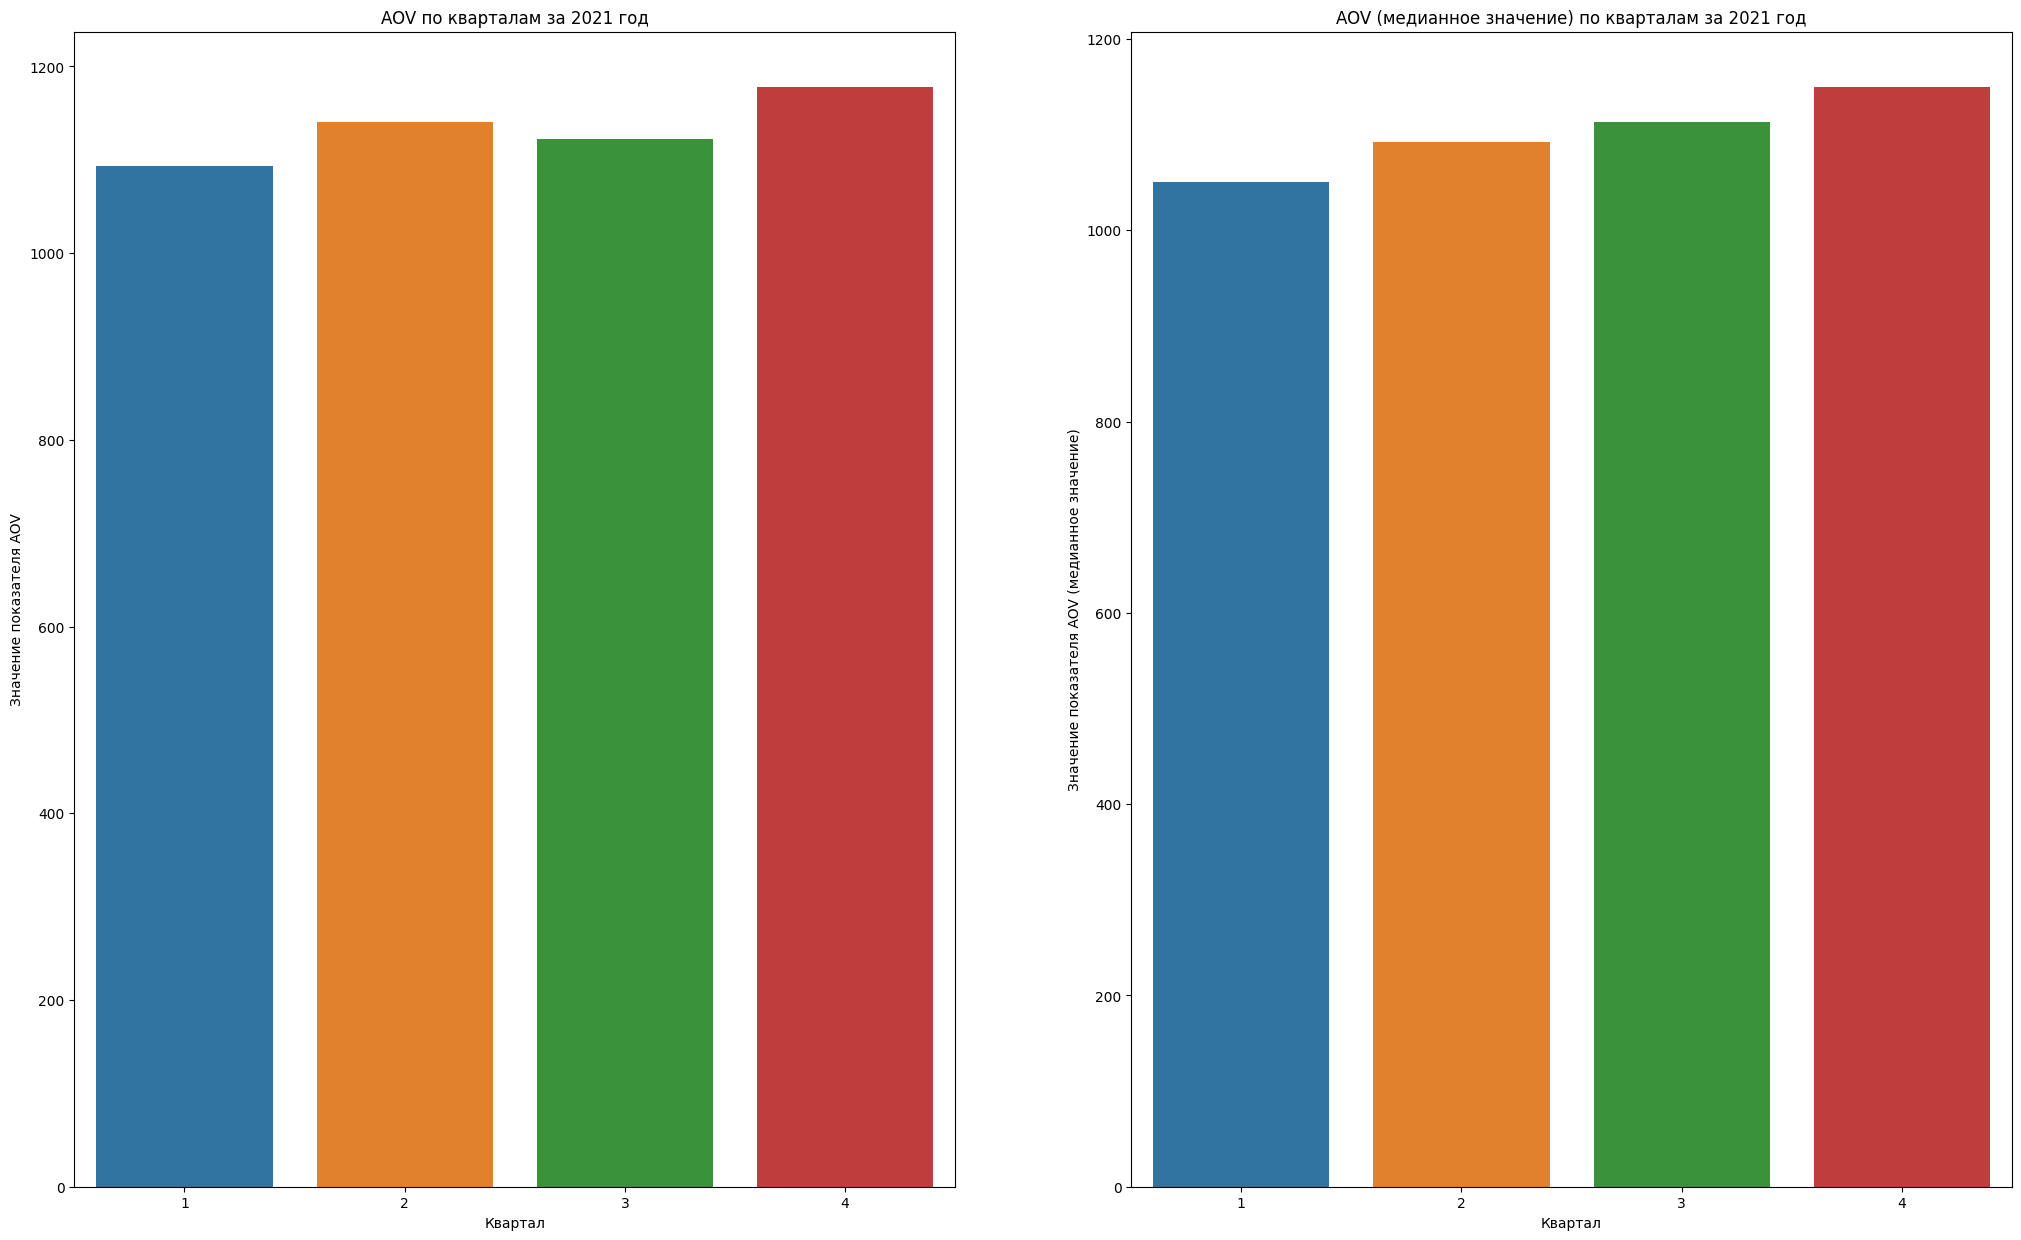

In [79]:
# построим графики по средним и медианным значениям за 2021 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2021'), x='quarter_', y='service_amount_mean', ax=axes[0])
ax1.set_title('AOV по кварталам за 2021 год')
ax1.set_xlabel('Квартал')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2021'), x='quarter_', y='service_amount_median', ax=axes[1])
ax2.set_title('AOV (медианное значение) по кварталам за 2021 год')
ax2.set_xlabel('Квартал')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

На графиках можно заметить, что AOV имеет тенденцию к росту по мере роста кварталов. Проанализируем аналогичные показатели за 2022 год.

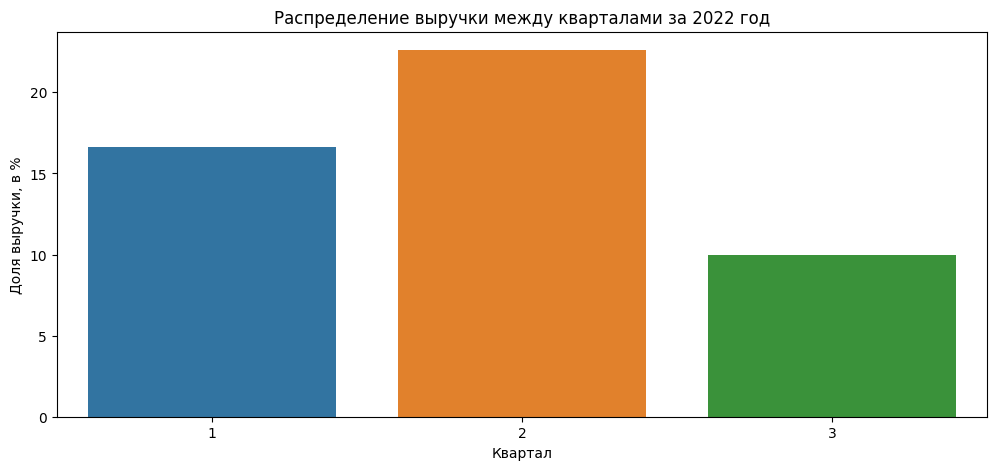

In [80]:
# построим график выручки за каждый квартал 2022 года
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2022'), x='quarter_', y='rev_perc')
plt.title('Распределение выручки между кварталами за 2022 год')
plt.xlabel('Квартал')
plt.ylabel('Доля выручки, в %')

plt.show()

В 2022 году наибольшую долю по выручке занимает 2 квартал, при этом в отличие от 2021 года, 3 квартал в 2022 году является наименее прибыльнм, а значение 1 квартала практически равно 4 кварталу 2022 года с небольшим превышением. Таким образом, можно сделать выводы о том, что в компании наблюдался постепенный рост выручки с 2021 года по 3 квартал 2022 года: далее возможны гипотезы, что рост прекратился вследствие нестабильной политической ситуации, однако не стоит забывать, что данные представлены только по август 2022 года, поэтому 3 квартал представлен не в полном объеме. Для анализа цены рассмотрим значения AOV.

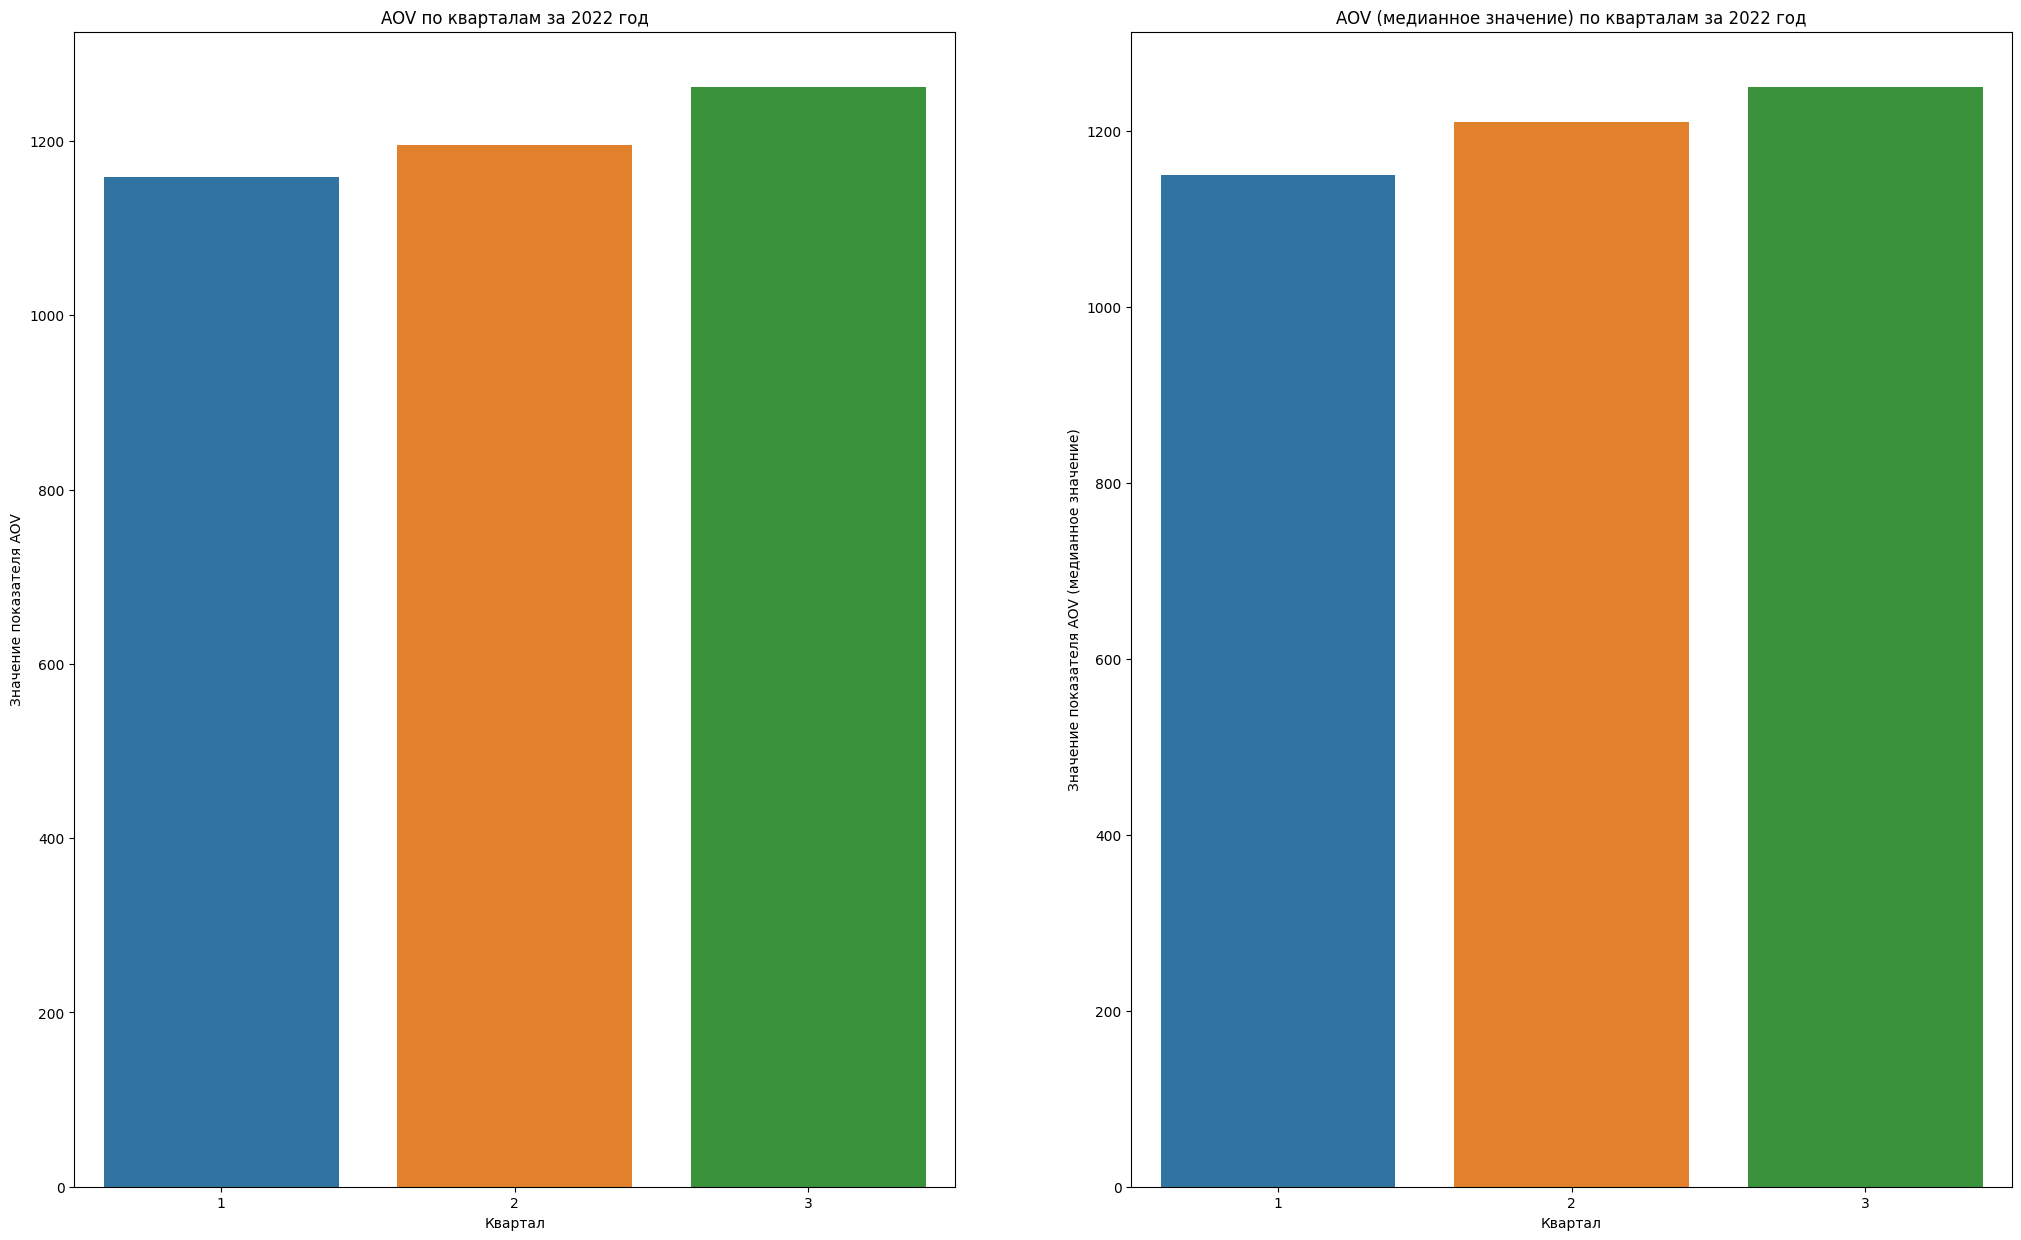

In [81]:
# построим графики по средним и медианным значениям за 2021 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2022'), x='quarter_', y='service_amount_mean', ax=axes[0])
ax1.set_title('AOV по кварталам за 2022 год')
ax1.set_xlabel('Квартал')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_quarter_year.query('year_ == 2022'), x='quarter_', y='service_amount_median', ax=axes[1])
ax2.set_title('AOV (медианное значение) по кварталам за 2022 год')
ax2.set_xlabel('Квартал')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

В целом, средний чек и его медианное значение имеют тенденцию к росту и достигают пикового значения в третий квартал 2022 года. Стоит отметить, что это не указывает на характер сезонности: в данных нет особо выделенной тенденции (например, что в зимнее время клиенты в большей степени склонны обращаться в клинику), но указывает на планомерный рост цены. Вполне вероятно, что необходимо сравнить стоимость лечения по категориям врачей, а также по различным типам анализов: например, вполне вероятно, что цены на зарубежные препараты выросли вследствие изменений в курсе рубля в 2022 года.

#### 4.3.3. Анализ ценовых факторов в разрезе профилей врачей и различных типов услуг

В рамках данной гипотезы мы предполагаем, что цены на стоимость услуг разнятся в силу различных категорий врачей, а также типов услуг, а причины разницы будут выяснены в рамках проверки каждой категории. Данная гипотеза наиболее сложна для анализа, так как мы работаем с предположениями в условиях: а) разных наименований услуг; б) отсутствии дополнительных данных, что наталкивает на использование внешних источников. Начнем с профилей врачей: ранее уже был проведен анализ средних цен по профилям и в целом, однако важно разобраться с тем, что внутри разных направлений существуют также и разные уровни - например, ведущий специалист и так далее.

In [82]:
# выведем уникальные стоимости услуг первичного приема за 2021 год
df.query('service_name.str.contains("Прием первичный") and year == 2021')['service_amount'].unique()

array([1470, 1755, 1540])

In [83]:
# выведем уникальные стоимости услуг первичного приема за 2021 год
df.query('service_name.str.contains("Прием") and year == 2022')['service_amount'].unique()

array([1380, 1540, 3970, 2810, 2950, 2655, 3250, 4190, 3350, 5250, 2150,
       2210, 5510, 2250, 1450, 1620, 4170, 4370, 2320, 1350, 3830, 3410])

Данные достаточно сильно разнятся, однако, вероятно, в силу того, что в категорию первичных приемов в 2022 году входят все категории врачей, а в 2021 году - только обычных специалистов, пусть и разных профилей. Попробуем найти данные по стоимости ведущих и главных специалистов в 2021 году.

In [84]:
# выведем уникальные стоимости услуг приема главного специалиста за 2021 год
df.query('service_name.str.contains("Прием главн") and year == 2021')['service_amount'].unique()

array([3780, 3970])

In [85]:
# выведем уникальные стоимости услуг приема ведущего специалиста за 2021 год
df.query('service_name.str.contains("Прием ведущ") and year == 2021')['service_amount'].unique()

array([2100, 2810])

Видим, что похоже стоимости также встречаются в массиве за 2022 год, что указывает на то, что гипотеза о том, что в категорию первичного и повторных приемов входят все категории врачей. Единственный вопрос - слишком больше значения, которые не встречаются в массивах за 2021 год, рассмотрим данные типы услуг более подробно.

In [86]:
# выведем стоимость услуг свыше 4000 за 2022 год
df.query('service_name.str.contains("Прием") and year == 2022 and service_amount > 4000')

record_id service_date  \
53956  32326835603   2022-03-02   
68968  32631551203   2022-05-21   
73885  32801122703   2022-06-20   
74157  32801152603   2022-06-26   
77746  32978657303   2022-07-26   
77881  32978671503   2022-07-09   
78157  32978699203   2022-07-28   
78273  32978711003   2022-07-07   
78274  32978711303   2022-07-07   
78307  32978714803   2022-07-09   
79136  32978798503   2022-07-05   
79330  32978818103   2022-07-12   
80736  32978960103   2022-07-23   
80746  32978961103   2022-07-28   
81606  32979047803   2022-07-01   
81817  32979069403   2022-07-26   
81896  32979077403   2022-07-17   
81928  32979080603   2022-07-14   
81945  32979082303   2022-07-19   
82012  32979089103   2022-07-29   
82128  32979100903   2022-07-10   
82176  32979105703   2022-07-17   
82183  32979106403   2022-07-26   
82233  32979111703   2022-07-07   
82237  32979112103   2022-07-12   
82584  33177659903   2022-08-19   
82783  33177683803   2022-08-13   
83533  33177830703   2022-08-25   
83670  33177849803   2022-08-30   
83873  33177887803   2022-08-16   
83901  33177890803   2022-08-20   
85048  33178102103   2022-08-19   

                                            service_name  service_amount  \
53956                          Прием хирурга, профессора            4190   
68968                                 Прием отоневролога            5250   
73885                   Прием отоларинголога, профессора            5510   
74157                       Прием гинеколога, профессора            5510   
77746  Прием проктолога, главного специалиста, врача ...            4170   
77881  Прием невролога, главного специалиста, врача -...            4170   
78157  Прием главного специалиста, врача-дерматолога,...            4170   
78273  Прием педиатра, главного специалиста, врача - ...            4370   
78274  Прием педиатра, главного специалиста, врача - ...            4370   
78307  Прием гастроэнтеролога, главного специалиста, ...            4170   
79136  Прием гинеколога, главного специалиста, врача ...            4170   
79330  Прием гинеколога, главного специалиста, врача ...            4170   
80736  Прием невролога, главного специалиста, врача -...            4170   
80746  Прием невролога, главного специалиста, врача -...            4170   
81606  Прием врача эндокринолога, руководителя направ...            5510   
81817  Прием травматолога-ортопеда, главного специали...            4370   
81896  Прием гинеколога, главного специалиста, врача ...            4170   
81928  Прием гинеколога, главного специалиста, врача ...            4170   
81945  Прием гинеколога, главного специалиста, врача ...            4170   
82012  Прием гастроэнтеролога, главного специалиста, ...            4170   
82128  Прием гинеколога, главного специалиста, врача ...            4170   
82176  Прием гинеколога, главного специалиста, врача ...            4170   
82183  Прием травматолога-ортопеда, главного специали...            4370   
82233  Прием гинеколога, главного специалиста, врача ...            4170   
82237  Прием гинеколога, главного специалиста, врача ...            4170   
82584  Прием гинеколога, главного специалиста, врача ...            4170   
82783  Прием невролога, главного специалиста, врача -...            4170   
83533  Прием гинеколога, главного специалиста, врача ...            4170   
83670  Прием гинеколога, главного специалиста, врача ...            4170   
83873  Прием педиатра, главного специалиста, врача - ...            4370   
83901  Прием главного специалиста, врача-дерматолога,...            4170   
85048  Прием врача эндокринолога, руководителя направ...            5510   

       service_number  insured sex_id  age_for_service_date  year age_group  \
53956               1   873187    2.0                    46  2022     40-49   
68968               1  1072993    1.0                    32  2022     30-39   
73885               1   774384    2.0                    27  2022     20-29   
74157               1   6522

Видим, что в датасете встречаются профессоры и руководители направлений, попробуем отыскать аналогичные стоимости за 2021 год.

In [87]:
# выведем уникальные стоимости услуг приема ведущего специалиста за 2021 год
df.query('service_name.str.contains("проф") or service_name.str.contains("руковод") and year == 2021')\
        ['service_amount'].unique()

array([3780, 4190, 5510])

Таким образом, в 2021 году данные категории врачей вынесены в отдельную категорию, но стоимость по ним также не сильно изменилась. Таким образом, можно говорить о том, что стоимость врачей по профилям остается схожей и если меняется, то незначительно. Наличие большого количества вариантов цены за приемв 2022 году объясняется наличием многопрофильных специалистов и различными типами приемов, что, по большей степени, объединено в 2021 году в одну категорию.

Для проведения более агрегированного анализа проведем попытку категоризации всех типов услуг. Стоит отметить, что данный прием обладает долей погрешности: не всегда можно точно определить ту или иную типу услуги по наименованию, поэтому есть вероятность, что часть услуг, которые можно отнести к той или иной категории, будут отнесены в категорию "Другие". Тем не менее, подобная проблема решается более фундаментальной проработкой перечня услуг и автоматизацией категоризации в дальнейшем, а так как сейчас такой цели нет, то попробуем сделать базовый вариант.

In [88]:
# объявим функцию для категоризации типов услуг
def set_category(row):
    # исходя из анализа датасета можно выделить следующие категории: приемы, анализы, массаж, процедуры и другие (например, вакцинации)
    if re.search('прием', row['service_name'], re.IGNORECASE):
        return 'приемы'
    elif re.search('анализ|взят|кров|моч|мазок|мазка|соскоб|пульс|кал|гистол|посев', row['service_name'], re.IGNORECASE):
        return 'анализы'
    elif re.search('массаж', row['service_name'], re.IGNORECASE):
        return 'массажи'
    elif re.search('терапи|процедур|обработ|смазыв|измер|осмот|измер|снят|ультразв|рентг|скан|экг|исслед|налож|ээг|тест|\
                   электрофорез|промыв|мрт|пункци|мскт|удал|вскрыт', row['service_name'], re.IGNORECASE):
        return 'процедуры'
    else:
        return 'другое'

In [89]:
# категоризируем услуги по типам
df['service_type'] = df.apply(set_category, axis=1)

Проведем анализ по полученным категориям: для этого рассчитаем выручку, а также среднее и медианное значение AOV на каждую категорию за 2 года. Вполне вероятно, что мы получим выводы, которые уже были известны ранее, так как проводился анализ по отдельным категориям, но агрегированные данные, возможно, будут восприниматься лучше.

In [90]:
# группируем данные по типу услуги
df_grouped_by_type = df.groupby('service_type').agg({'record_id': 'count', 'service_amount': 'sum', 'service_amount': \
                                                   ['sum', 'mean', 'median']}).reset_index()

df_grouped_by_type.columns = ['_'.join(col).strip() for col in df_grouped_by_type.columns.values]

df_grouped_by_type['count_perc'] = (df_grouped_by_type['record_id_count'] /
                                           df_grouped_by_type['record_id_count'].sum()) * 100

df_grouped_by_type['rev_perc'] = (df_grouped_by_type['service_amount_sum'] /
                                           df_grouped_by_type['service_amount_sum'].sum()) * 100

df_grouped_by_type

service_type_  record_id_count  service_amount_sum  service_amount_mean  \
0       анализы            18803            12182743           647.914854   
1        другое            17537            13796886           786.730113   
2       массажи             1841             2311923          1255.797393   
3        приемы            26289            38952632          1481.708395   
4     процедуры            20899            32304149          1545.727020   

   service_amount_median  count_perc   rev_perc  
0                  450.0   22.025560  12.238018  
1                  600.0   20.542586  13.859485  
2                 1218.0    2.156521   2.322413  
3                 1470.0   30.794551  39.129366  
4                 1270.0   24.480783  32.450718

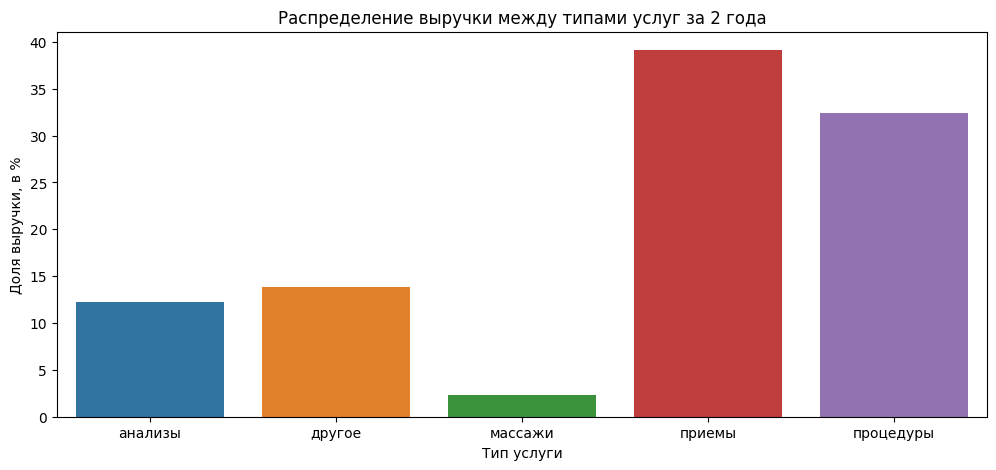

In [91]:
# построим график выручки за каждый тип услуг
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_type, x='service_type_', y='rev_perc')
plt.title('Распределение выручки между типами услуг за 2 года')
plt.xlabel('Тип услуги')
plt.ylabel('Доля выручки, в %')

plt.show()

С учетом вероятноной погрешности при допущенной категоризации можно заметить, что большую часть выручки составляют приемы и процедуры. При этом, если обратиться к таблице выше, то можно говорить о том, что по посещемости категория приемов снова лидирует, однако крупные показатели и по другим категориям - например, процедурам и анализам. Тем не менее, большую часть выручки формируют именно приемы, вероятно, в силу более низкой стоимости анализов и услуг в категории "Другое" (например, вакцим). Рассчитаем AOV по типам услуг, чтобы убедиться в этом.

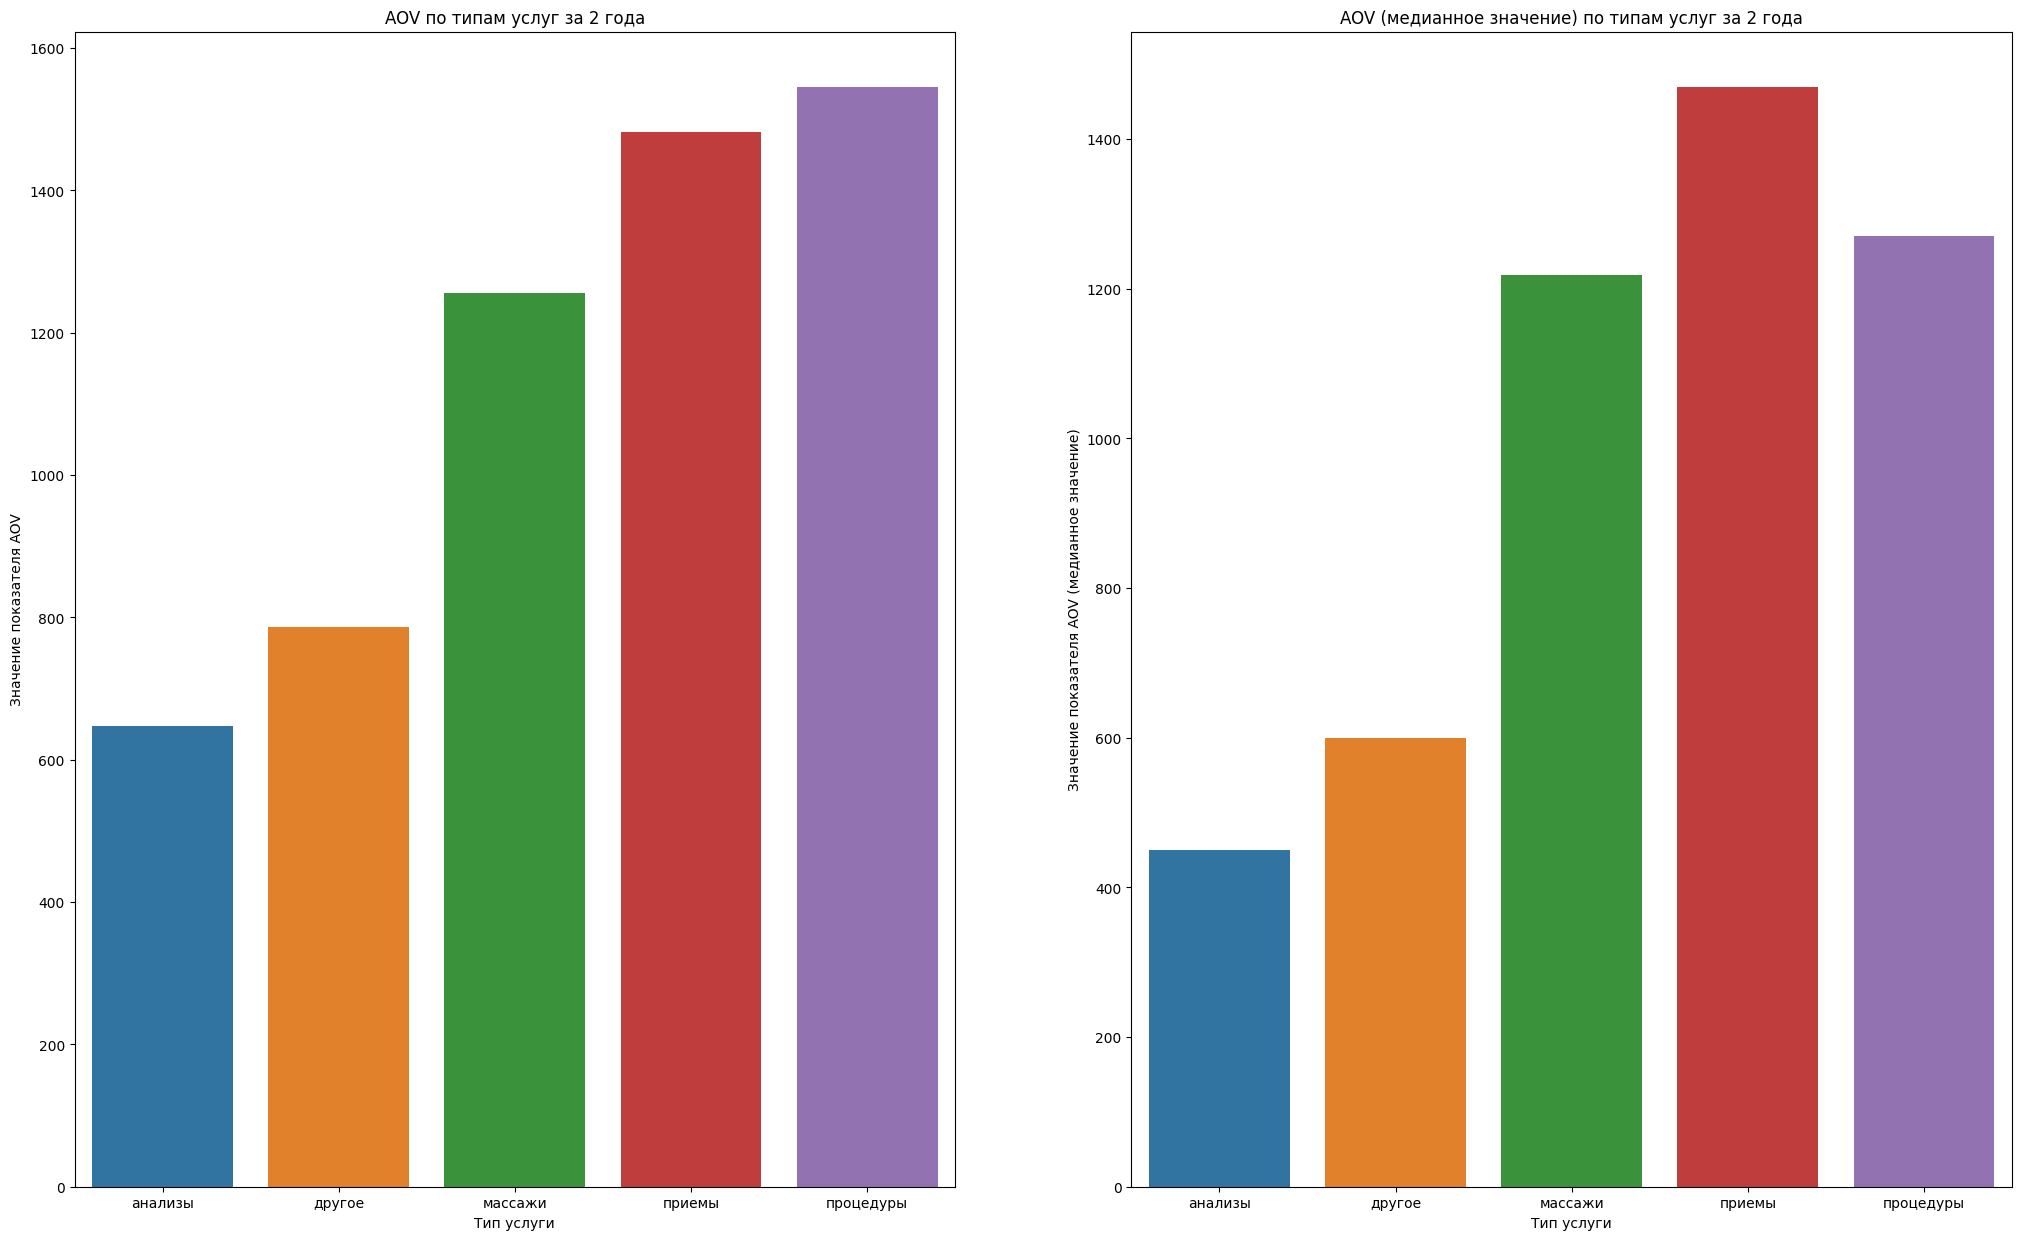

In [92]:
# построим графики по средним и медианным значениям за оба года
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_type, x='service_type_', y='service_amount_mean', ax=axes[0])
ax1.set_title('AOV по типам услуг за 2 года')
ax1.set_xlabel('Тип услуги')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_type, x='service_type_', y='service_amount_median', ax=axes[1])
ax2.set_title('AOV (медианное значение) по типам услуг за 2 года')
ax2.set_xlabel('Тип услуги')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

При анализе AOV по категориям будем руководствоваться медианным значением - все-таки данные были категоризованы с погрешностью, что способствует появлению выбросов в рамках какой-либо категории. На графиках можно заметить, что наибольшую стоимость составляют именно приемы - больше 1400 руб., а наименьшую - анализы и услуги в категории "Другое" - в районе 650-800 руб. Процедуры также обладают сравнительно большой медианной стоимостью, что указывает на достаточно крупные значения в выручке. Рассмотрим аналогичные показатели, но за каждый год по отдельности.

In [93]:
# группируем данные по типу услуги и году
df_grouped_by_type_year = df.groupby(['year', 'service_type']).agg({'record_id': 'count', 'service_amount': 'sum', \
                                                               'service_amount': ['sum', 'mean', 'median']}).reset_index()

df_grouped_by_type_year.columns = ['_'.join(col).strip() for col in df_grouped_by_type_year.columns.values]

df_grouped_by_type_year['count_perc'] = (df_grouped_by_type_year['record_id_count'] /
                                           df_grouped_by_type_year['record_id_count'].sum()) * 100

df_grouped_by_type_year['rev_perc'] = (df_grouped_by_type_year['service_amount_sum'] /
                                           df_grouped_by_type_year['service_amount_sum'].sum()) * 100

In [94]:
# построим график выручки за каждый тип услуг за 2021 год
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_type_year.query('year_ == 2021'), x='service_type_', y='rev_perc')
plt.title('Распределение выручки между типами услуг за 2021 год')
plt.xlabel('Тип услуги')
plt.ylabel('Доля выручки, в %')

plt.show()

In [95]:
# построим графики по средним и медианным значениям за 2021 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_type_year.query('year_ == 2021'), x='service_type_', y='service_amount_mean', \
                  ax=axes[0])
ax1.set_title('AOV по типам услуг за 2021 год')
ax1.set_xlabel('Тип услуги')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_type_year.query('year_ == 2021'), x='service_type_', y='service_amount_median', \
                  ax=axes[1])
ax2.set_title('AOV (медианное значение) по типам услуг за 2021 год')
ax2.set_xlabel('Тип услуги')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

Аналогичную тенденцию видим и в рамках анализа AOV. Рассмотрим показатели за 2022 год: вполне вероятно, что тенденция будет аналогичной, но важно рассмотреть разницу в медианных значениях - так сможем понять какая категория претерпела изменения.

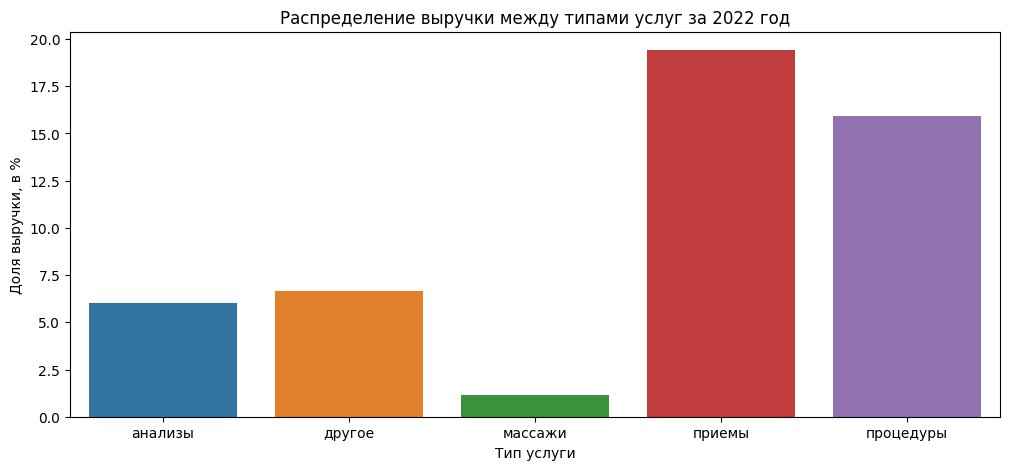

In [96]:
# построим график выручки за каждый тип услуг за 2022 год
plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped_by_type_year.query('year_ == 2022'), x='service_type_', y='rev_perc')
plt.title('Распределение выручки между типами услуг за 2022 год')
plt.xlabel('Тип услуги')
plt.ylabel('Доля выручки, в %')

plt.show()

In [97]:
# построим графики по средним и медианным значениям за 2022 год
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

# строим графики
ax1 = sns.barplot(data=df_grouped_by_type_year.query('year_ == 2022'), x='service_type_', y='service_amount_mean', \
                  ax=axes[0])
ax1.set_title('AOV по типам услуг за 2022 год')
ax1.set_xlabel('Тип услуги')
ax1.set_ylabel('Значение показателя AOV')

ax2 = sns.barplot(data=df_grouped_by_type_year.query('year_ == 2022'), x='service_type_', y='service_amount_median', \
                  ax=axes[1])
ax2.set_title('AOV (медианное значение) по типам услуг за 2022 год')
ax2.set_xlabel('Тип услуги')
ax2.set_ylabel('Значение показателя AOV (медианное значение)')

plt.show()

Как и предполагалось, динамика показателя AOV по категориям услуг в 2022 аналогична 2021 году. Тем не менее, разница имеется:
- в 2022 году выросла стоимость приемов, при этом стремится к значению в 1600 руб.
- стоимость анализов и услуг в категории "Другое" выросли до 500-700 руб.
- стоимость массажа также увеличилась до 1300 руб., а стоимость процедур осталась практически без изменений

Рост цен на анализы и услуги в категории "Другое" можно объяснить экономической ситуацией в стране: при анализе сезонности было выяснено, что средний и медианный AOV имели тенденцию к увеличению к концу 2022 года, что связано с инфляцией, а также ростом курса валют, что сказывается напрямую на импортируемых материалах, а их множество в медицинской сфере. Рост стоимости приемов и массажа может быть связан с несколькими факторами и определяться как динамикой рынка труда/средним увеличением заработной платы врачей по рынку, так и непосредственно с изменением финансовой политики клиники, нацеленной на другие показатели прибыли.

**Выводы по исследовательскому анализу данных и проверке гипотез:**
- В рамках исследования были проанализированы распределения поло-возрастных, а также стоимостных показателей. Выяснили, что большая часть клиентов клиники - пациенты женского пола в возрасте 20-49 лет. Тажке рассмотрели распределение посещаемости клиентов клиники по профилям врачам: среди первичных приемов лидируют терапевт, отоларинголог и невролог, а среди повторных - гинеколог, терапевт и невролог. Стоит отметить, что данные выводы относятся только к 2022 году - в 2021 году отчетность велась иначе и распределение по профилям врачей посмотреть невозможно;
- При анализе стоимостных показателей выяснили, что цены 2022 года по отношению к 2021 претерпели незначительные изменения: в 2022 году компания заработала меньше выручки (незначительная разница с 2021 годом), однако важно учитывать факт того, что данные за 2022 год представлены только по август включительно, поэтому вполне вероятно, что в 2022 году компания заработала больше при анализе отсутствующих данных. AOV в 2022 году больше, чем в 2021: в районе 1200 руб. и 1100 руб., соответственно.

Так как задачей стоял анализ факторов изменения цены, то были выдвинуты 3 гипотезы, а также проанализированы ряд показателей:
- Гипотеза №1 - поло-возрастные характеристики влияют на формирование цены. Данная гипотеза отклоняется: несмотря на то, что женщины в большей степени склонны тратить в клинике и показатель AOV выше, чем у мужчин, ценовой дискриминации на общие услуги выявлено не было, как и для разных возрастных категорий. При этом не отрицается, что стоимость исключительно женских услуг может быть несколько выше, однако для проверки данной гипотезы необходимо провести более укрупненную категоризацию данных по женским, мужским и общим услугам, что требует проведения отдельного исследования и работы с большой базой наименований услуг;
- Гипотеза №2 - стоимость услуг подвержена фактору сезонности. Данная гипотеза отклоняется: сезонность выявлена не была, однако правомерно говорить о том, что AOV рост по мере движения к концу 2022 года, что, возможно, связано с экономической ситуацией в стране и ростом курса валют, что сказывается на стоимости импортируемых медикаментов.
- Гипотеза №3 - типы услуг влияют на формирование стоимости. Данная гипотеза подвердилась: во-первых, тип услуги так или иначе влияет на стоимость услуги вне зависимости от периода - например, анализы стоят на порядок дешевле, чем массаж. Во-вторых, распределение медианного AOV по типам услуг за оба года одинаково, однако в 2022 году произошел рост данного показателя, вероятно, на фоне экономической ситуации или политики клиники в отношении ценообразования (например, произошел пересмотр целевого показателя прибыли). При этом выводам, разработанным в рамках данной гипотезы, следует доверять осторожно, так как категоризация была проведена с долей некоторой погрешности.

Для более точных выводов необходимо:
- Провести ряд дополнительных категоризаций и автоматизировать процесс наименования услуг (возможно, даже стандартизировать наименования за оба периода для проведения более точного сопоставительного анализа)
- Получить дополнительную информацию по стратегии и финансовой политики компании, чтобы с уверенностью говорить о том, является ли изменение стоимости услуг следствием учета внешних экономических факторов и так далее.

## Общие выводы:

В рамках исследования были проведены следующие этапы работы:

### 1. Подключение необходимых библиотек и датасета
В работе были задействованы библиотеки, необходимые для анализа данных, построения визуализации, поиска значений в строковых данных, а также удаленном подключении файла с Google Drive.

### 2. Предобработка данных
В рамках данного этапа работы данные были проанализированы на наличие пропусков, дубликатов и некорректных форматов данных. - В ходе работы был изменен тип данных в колонке `service_date` с object на datetime;
- Единственная колонка с пропусками - `sex_id`, заменили пропуски на заглушку для дальнейшего анализа и визуализаций;
- Дубликатов в датасете обнаружено не было.

### 3.1 Исследовательский анализ данных
- В рамках исследования были проанализированы распределения поло-возрастных, а также стоимостных показателей. Выяснили, что большая часть клиентов клиники - пациенты женского пола в возрасте 20-49 лет. Тажке рассмотрели распределение посещаемости клиентов клиники по профилям врачам: среди первичных приемов лидируют терапевт, отоларинголог и невролог, а среди повторных - гинеколог, терапевт и невролог. Стоит отметить, что данные выводы относятся только к 2022 году - в 2021 году отчетность велась иначе и распределение по профилям врачей посмотреть невозможно;
- При анализе стоимостных показателей выяснили, что цены 2022 года по отношению к 2021 претерпели незначительные изменения: в 2022 году компания заработала меньше выручки (незначительная разница с 2021 годом), однако важно учитывать факт того, что данные за 2022 год представлены только по август включительно, поэтому вполне вероятно, что в 2022 году компания заработала больше при анализе отсутствующих данных. AOV в 2022 году больше, чем в 2021: в районе 1200 руб. и 1100 руб., соответственно.

### 3.2 Выдвижение и проверка гипотез факторов изменения цены
- Гипотеза №1 - поло-возрастные характеристики влияют на формирование цены. Данная гипотеза отклоняется: несмотря на то, что женщины в большей степени склонны тратить в клинике и показатель AOV выше, чем у мужчин, ценовой дискриминации на общие услуги выявлено не было, как и для разных возрастных категорий. При этом не отрицается, что стоимость исключительно женских услуг может быть несколько выше, однако для проверки данной гипотезы необходимо провести более укрупненную категоризацию данных по женским, мужским и общим услугам, что требует проведения отдельного исследования и работы с большой базой наименований услуг;
- Гипотеза №2 - стоимость услуг подвержена фактору сезонности. Данная гипотеза отклоняется: сезонность выявлена не была, однако правомерно говорить о том, что AOV рост по мере движения к концу 2022 года, что, возможно, связано с экономической ситуацией в стране и ростом курса валют, что сказывается на стоимости импортируемых медикаментов.
- Гипотеза №3 - типы услуг влияют на формирование стоимости. Данная гипотеза подвердилась: во-первых, тип услуги так или иначе влияет на стоимость услуги вне зависимости от периода - например, анализы стоят на порядок дешевле, чем массаж. Во-вторых, распределение медианного AOV по типам услуг за оба года одинаково, однако в 2022 году произошел рост данного показателя, вероятно, на фоне экономической ситуации или политики клиники в отношении ценообразования (например, произошел пересмотр целевого показателя прибыли). При этом выводам, разработанным в рамках данной гипотезы, следует доверять осторожно, так как категоризация была проведена с долей некоторой погрешности.

### 4. Дальнейшее направление работы
В дальнейшем предлагается поработать с перечнем наименований услуг и стандартизировать их для обоих периодов, а также провести дополнительную и более точную категоризацию по половым отличиям и типам услуг, так как базовый анализ, проведенный в рамках исследования, обладает некоторой погрешностью. Кроме этого, доступ к стратегической и финансовой составляющим компании способствовал бы более точному формулированию выводов.